# Simulation Description
This notebook simulates the AGWS Active Optics / Phasing control loop required to run BEFORE the AO loop is actually closed.

This simulation setup will be also used to evaluate the Wide Field Phasing Testbed (WFPT) refractive vs reflective designs.

In [1]:
#----- CEO: GMT ray-tracing and wavefront sensing simulator
import ceo

#----- System related packages
import sys
import datetime
import os.path
import csv
#import subprocess

#----- Math and Scientific Computing
import math
import numpy as np
import cupy as cp
from scipy import ndimage
from scipy import signal
import scipy.io as sio

#----- Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import IPython
#%pylab inline

## General simulation flags and options

In [2]:
#---------- Simulate control loops
simul_ActO_control = True   
    
if simul_ActO_control==True:
    M1_n_modes = 15
    M1_mirror_modes = "bending modes"

#---------- Disturbances
simul_turb  = False     # Simulate atmospheric turbulence

#---------- Performance evaluation
eval_perf_onaxis    = True
eval_perf_field     = False
eval_perf_modal     = False   # project Residual phase
eval_perf_sps       = True

#---------- General stuff
tid = ceo.StopWatch()
VISU=True

## Telescope initialization

In [3]:
#---- Telescope sampling parameters
D = 25.5                # [m] Diameter of simulated square (slightly larger than GMT diameter) 
PupilArea = 357.0       # [m^2] Takes into account baffled segment borders
tel_throughput = 0.9**4 # M1 + M2 + M3 + GMTIFS dichroic = 0.9^4 

In [4]:
# Telescope
if simul_ActO_control==True:
        gmt = ceo.GMT_MX(M1_N_MODE=M1_n_modes, M1_mirror_modes = M1_mirror_modes)        
else:
    gmt = ceo.GMT_MX()

### Retrieve the M1 bending modes shapes and visualize them just for fun

In [85]:
# Retrieve M1 bending modes
M = gmt.M1.modes.M.host()

print(M.shape)

#Create circular mask
rows = gmt.M1.modes.N_SAMPLE
cols = gmt.M1.modes.N_SAMPLE
nsets = gmt.M1.modes.N_SET
nbms = gmt.M1.modes.N_MODE

xVec = np.linspace(-1,1,cols)
yVec = np.linspace(-1,1,rows)
[x,y] = np.meshgrid(xVec,yVec) # rows x cols
r = np.hypot(x,y)

#Mask for outer segments
M1masko = np.full((rows,cols),np.nan)
M1masko[(r <= 1)]=1.0
M1npo = np.sum(r <= 1)

#Mask for central segment
M1maskc = np.full((rows,cols),np.nan)
M1maskc[np.logical_and(r <= 1, r >= 0.344)] = 1.0
M1npc = np.sum(M1maskc == 1)

(40401, 324)


RMS of BM mode 4 is: 0.01


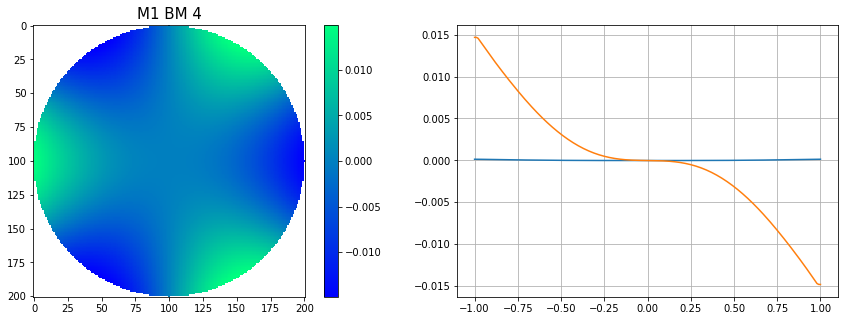

In [6]:
# Choose BM to display
this_set = 0    # 0: outer segments;    1: central segment
this_bm = 4

if this_set == 0:
    M1mask = M1masko
    M1np = M1npo
else:
    M1mask = M1maskc
    M1np = M1npc

BMmap = np.reshape(M[:,this_set*nbms+this_bm], (rows,cols) )*M1mask
BMrms = np.sqrt( np.sum(BMmap[M1mask==1]**2)/M1np )
print("RMS of BM mode %d is: %.2f"%(this_bm, BMrms))
fig, (ax1,ax2) = plt.subplots(ncols=2)
fig.set_size_inches(15,5)
imm = ax1.imshow(BMmap, cmap=plt.cm.winter)
fig.colorbar(imm, ax=ax1)
ax1.set_title('M1 BM %d'%(this_bm), fontsize=15)

ax2.plot(xVec,BMmap[:,int(cols/2)])
ax2.plot(yVec,BMmap[int(rows/2),:])
ax2.grid()

## AGWS wavefront sensors initialization

### AGWS guide stars

In [7]:
if simul_ActO_control==True:
    
    asterism_type = 'Dummy' # Choose between 'Besancon_GP', 'Besancon_GP_AB', and 'Dummy'
    N_GS_PS = 3             # Asterism of 3 or 4 stars
    
    if asterism_type == 'Dummy':
        alpha_ps = 8.0*60.  # Radius of circle where GSs are located [in arcsec]
    else:
        asterism_id = 33    # Choose ID of desired asterism on database.
        np.save('asterism_id',asterism_id)        

    #----- AGWS infrared phasing channels
    sps_band = "J"
    sps_mag = 12.0
    J_bkgd_mag = 16.2              # J-band sky bkgd (mag/arcsec^2); Tech Note GMT-02274, rev 2.4
    J_e0 = 1.88e12/368.*PupilArea  # ph/s in J band over the GMT pupil

    #----- AGWS visible AcO channels
    sh_band = "R+I"
    RI_e0 = 9.00e12 /368.*PupilArea  # ph/s in R+I band over the GMT pupil (correction factor applied)
    RI_bkgd_mag = 19.6       # sky background [mag arcsec-2] in R+I band: 20.4-18.8 -> mean value: 19.6
    sh_mag = 10.0
    sh_fwhm = 3.16

Selected asterism: 
mag(J) Zenith(')  Azimuth(deg)
12.00 	  8.00 	    0.0
12.00 	  8.00 	    120.0
12.00 	  8.00 	    240.0


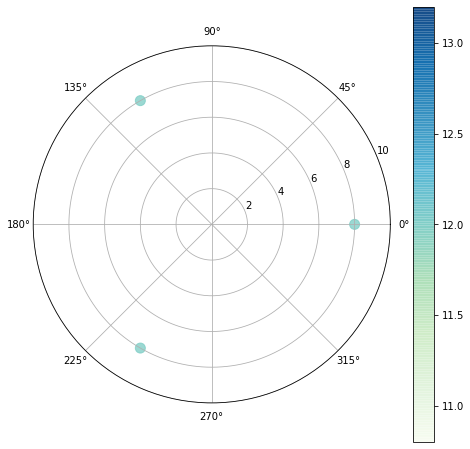

In [8]:
if simul_ActO_control==True:

    if asterism_type == 'Dummy':
        
        zenith_angle_agws  = np.ones(N_GS_PS)*alpha_ps*math.pi/180/3600 # in radians
        azimuth_angle_agws = np.arange(N_GS_PS)* (360.0/N_GS_PS) * (math.pi/180) # in radians
        sps_mag = np.ones(N_GS_PS)*sps_mag
        sh_mag  = np.ones(N_GS_PS)*sh_mag

    elif asterism_type == 'Besancon_GP':

        _asterism_zenith = []
        _asterism_azimuth = []
        _asterism_magnitude = []
        _asterism_Jmag = []

        with open('asterisms_phasing.txt', 'rb') as csvfile:
            asterisms = csv.reader(csvfile)
            for row in asterisms:
                _asterism_zenith.append( float(row[0])*ceo.constants.ARCMIN2RAD )
                _asterism_azimuth.append( float(row[1]) )
                _asterism_magnitude.append( float(row[2]) )
                _asterism_Jmag.append( float(row[3]) )

        asterism_id = np.load('asterism_id.npy')
        asterism_id = int(asterism_id.tolist())
        print("Asterism ID: %d"%asterism_id)

        asterism_zenith = np.array(_asterism_zenith[asterism_id*3:(1+asterism_id)*3])
        asterism_azimuth = np.array(_asterism_azimuth[asterism_id*3:(1+asterism_id)*3])
        asterism_magnitude = np.array(_asterism_magnitude[asterism_id*3:(1+asterism_id)*3])
        asterism_Jmag = np.array(_asterism_Jmag[asterism_id*3:(1+asterism_id)*3])

        ordmag = (np.argsort(asterism_Jmag))
        sps_mag = (asterism_Jmag[ordmag])[0:3]
        zenith_angle_agws = (asterism_zenith[ordmag])[0:3]
        azimuth_angle_agws = (asterism_azimuth[ordmag])[0:3]
        
    elif asterism_type == 'Besancon_GP_AB':
        
        _asterism_X = []
        _asterism_Y = []
        _asterism_Jmag = []

        with open('agws_sps_aster.txt', 'rb') as csvfile:
            asterisms = csv.reader(csvfile)
            headers = asterisms.next()
            for row in asterisms:
                _asterism_X.append(   np.array((float(row[0]),float(row[3]),float(row[6]))))
                _asterism_Y.append(   np.array((float(row[1]),float(row[4]),float(row[7]))))
                _asterism_Jmag.append(np.array((float(row[2]),float(row[5]),float(row[8]))))
            
        asterism_zenith = np.sqrt(np.array([X**2 for X in _asterism_X]) + \
                                  np.array([Y**2 for Y in _asterism_Y])).T * ceo.constants.ARCSEC2RAD
        
        asterism_azimuth = np.arctan2( np.array([Y for Y in _asterism_Y]), 
                                       np.array([X for X in _asterism_X])).T

        asterism_Jmag = np.array(_asterism_Jmag).T
        nast= asterism_Jmag.shape[1]
        
        dummy, badast = np.where( asterism_Jmag == 0)
        goodast = list(set(range(nast)) - set(badast.tolist()))
        asterism_zenith  = asterism_zenith[:,goodast]
        asterism_azimuth = asterism_azimuth[:,goodast]
        asterism_Jmag = asterism_Jmag[:,goodast]
        nast= asterism_Jmag.shape[1]
        
        asterism_id = np.load('asterism_id.npy')
        asterism_id = int(asterism_id.tolist())
        print("Asterism ID: %d"%asterism_id)
        
        sps_mag = asterism_Jmag[:,asterism_id]
        zenith_angle_agws  =  asterism_zenith[:,asterism_id]
        azimuth_angle_agws = asterism_azimuth[:,asterism_id]
        
    print("Selected asterism: \nmag(J) Zenith(')  Azimuth(deg)")
    for x in range(N_GS_PS): 
        print("%3.2f \t  %1.2f \t    %3.1f"%(sps_mag[x], zenith_angle_agws[x]*ceo.constants.RAD2ARCMIN, 
                                                azimuth_angle_agws[x]*180/math.pi))

    if VISU==True:
        fig = plt.figure(figsize=(8,8))
        ax  = plt.subplot(111,polar=True)
        zen = zenith_angle_agws*ceo.constants.RAD2ARCMIN
        azi = azimuth_angle_agws
        c = ax.scatter(azi,zen,c=sps_mag,s=100,cmap=plt.cm.GnBu)
        ax.set_rmax(10)
        c.set_alpha(0.75)
        #c.set_clim([11,13.5])

        #c.set_edgecolor('None')
        plt.colorbar(c,ax=ax)

### AGWS Phasing Sensors

In [9]:
if simul_ActO_control==True:   
    
    #----- AGWS SPS parameters:
    sps_nPx = 481                # number of rays to propagate from GS to SPS
    sps_type = 'DFS'              # Choose between "ideal" or "DFS"
    sps_throughput = 0.65*0.75   # Table 3, GMT-DOC-01404
    sps_fov = 2.8                # arcsec diameter
    sps_dispersion = 5.0
    sps_RONval = 0.0 #0.35            # [e- rms]
    sps_mask_size = 1.5     # arcsec
    sps_lobe_detection = 'peak_value'
    sps_nyquist_factor = 1
    sps_dark_cur = 0.0 #48.0 # additional background in e-/pix/s (dark current + allocated cryo filter leak) 
    sps_excess_noise = 1.0 #1.25
 
    sps_simul_phot = False
    sps_simul_bkgd = False
    sps_seed = 1928

In [10]:
if simul_ActO_control==True:   

    #------------------ Initialize SPS GS objects
    gsps = ceo.Source(sps_band, magnitude=sps_mag,
                      zenith=zenith_angle_agws,azimuth=azimuth_angle_agws,
                      rays_box_size=D,rays_box_sampling=sps_nPx,rays_origin=[0.0,0.0,25])
    
    print('Photometry in J band:')
    for x in range(gsps.N_SRC):
        print('Number of simulated GS%d photons [ph/s/m^2]: %.1f'%(x,gsps.nPhoton[x]))
        print('Number of  expected GS%d photons [ph/s/m^2]: %.1f'%(x,J_e0*10**(-0.4*sps_mag[x])/PupilArea))

Photometry in J band:
Number of simulated GS0 photons [ph/s/m^2]: 81780.5
Number of  expected GS0 photons [ph/s/m^2]: 80967.4
Number of simulated GS1 photons [ph/s/m^2]: 81780.5
Number of  expected GS1 photons [ph/s/m^2]: 80967.4
Number of simulated GS2 photons [ph/s/m^2]: 81780.5
Number of  expected GS2 photons [ph/s/m^2]: 80967.4


Size of DFS detector mask [pix]: 20


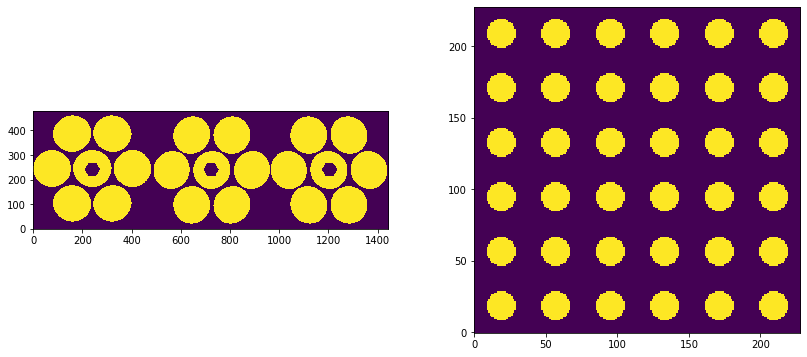

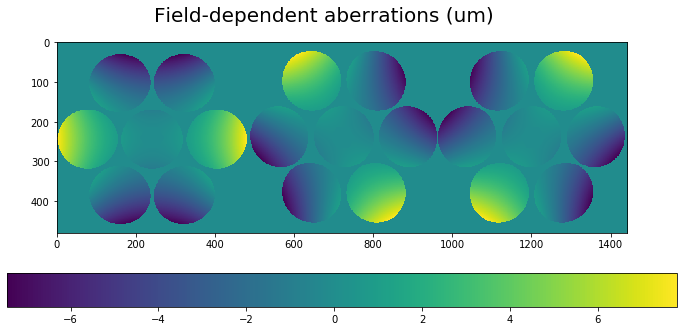

In [11]:
if simul_ActO_control==True:
    sps_p = D/(sps_nPx-1)  #needed for Source.ray_tracing()
    
    #------------------ Initialize SPS objects
    if sps_type == 'ideal':
        ps = ceo.IdealSegmentPistonSensor(D, sps_nPx, segment='edge')
    elif sps_type == 'DFS':
        ps = ceo.DispersedFringeSensor(gmt.M1, gsps, dispersion=sps_dispersion,
                                       field_of_view=sps_fov, nyquist_factor=sps_nyquist_factor)
        ps.lobe_detection = sps_lobe_detection
        ps.camera.photoelectron_gain = sps_throughput
        if sps_mask_size > 0: ps.init_detector_mask(sps_mask_size)            

    #------------------- Calibrate DFS
    gmt.reset()
    gsps.reset()
    gmt.propagate(gsps)
    ph_fda_agws = gsps.phase.host(units='micron').T
    Pmask = gsps.wavefront.amplitude.host().reshape((sps_nPx*N_GS_PS,sps_nPx)).T
    
    if sps_type == 'DFS':
        ps.INIT_ALL_ATTRIBUTES = True
        
    ps.calibrate(gsps)

    if eval_perf_sps==True:
        seg_pist_sps_ref = gsps.piston(where='segments', units_exponent=-9)

    if VISU == True and sps_type == 'DFS':
        fig1, (ax1,ax2) = plt.subplots(ncols=2)
        fig1.set_size_inches((14,6))
        ax1.imshow(Pmask, origin='lower')
        ax2.imshow(ps.fft_mask.f.host().reshape((ps.camera.N_PX_FRAME,ps.camera.N_PX_FRAME)),
                   origin='lower')
        
        fig2, ax = plt.subplots()
        fig2.set_size_inches(20,5)
        fig2.suptitle('Field-dependent aberrations (um)', fontsize=20)
        imm = ax.imshow(ph_fda_agws, interpolation='None')
        fig2.colorbar(imm, orientation='horizontal', shrink=0.6)

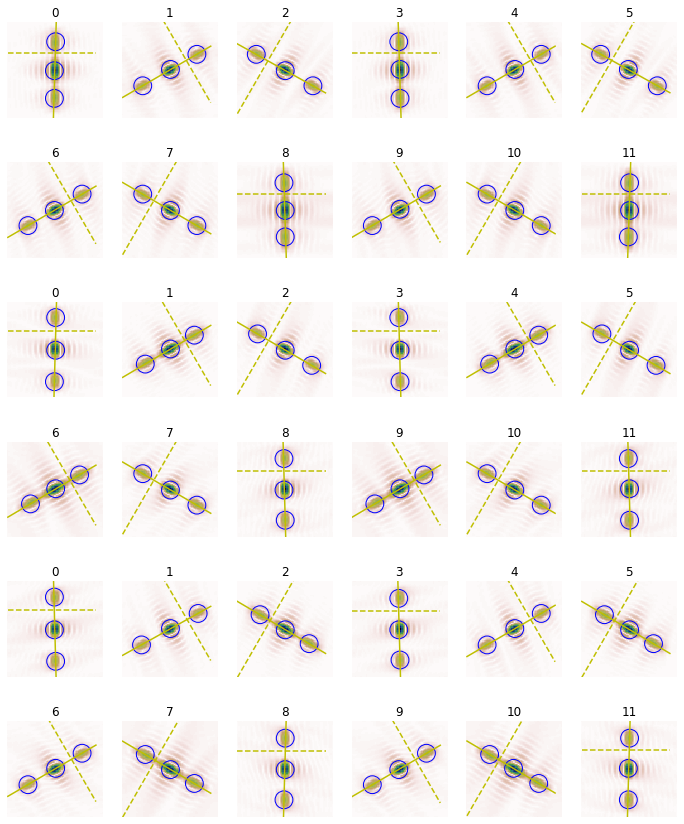

In [12]:
if simul_ActO_control==True:
    
    #------ Show DFS reference imagettes
    def show_sps_imagettes():
        dataCube = ps.get_data_cube(data_type='fftlet')

        fig, ax = plt.subplots(ps.camera.N_SIDE_LENSLET,ps.camera.N_SIDE_LENSLET)
        fig.set_size_inches((12,15))
        xvec = np.arange(0,ps.camera.N_PX_IMAGE,10)
        for k in range(gsps.N_SRC*12):
            (ax.ravel())[k].imshow(np.sqrt(dataCube[:,:,k]), cmap=plt.cm.gist_earth_r, origin='lower')
            (ax.ravel())[k].autoscale(False)
            if ps.INIT_ALL_ATTRIBUTES == True:
                (ax.ravel())[k].plot(xvec, xvec*ps.pl_m[k] + ps.pl_b[k], 'y')
                (ax.ravel())[k].plot(xvec, xvec*ps.pp_m[k] + ps.pp_b[k], 'y--')
                for pp in range(3):
                    c1 = plt.Circle((ps.blob_data[k,pp,1], ps.blob_data[k,pp,0]),radius=np.sqrt(2)*ps.blob_data[k,pp,2],
                                color='b', fill=False)
                    (ax.ravel())[k].add_patch(c1)
            (ax.ravel())[k].set_title('%d'%(k%12), fontsize=12)

        for k in range(ps.camera.N_SIDE_LENSLET**2):
            (ax.ravel())[k].axis('off')

    if VISU == True and sps_type == 'DFS':
        show_sps_imagettes()

#### Background noise initialization

In [42]:
#----- Estimate the effective area of DFS subapertures (in number of simulation pixels)
if simul_ActO_control==True:
    
    # on-axis GS for perf. evalulation and to compute GMT area in pixels^2
    gs = ceo.Source(sps_band, zenith=0., azimuth=0.,
                  rays_box_size=D, rays_box_sampling=sps_nPx, rays_origin=[0.0,0.0,25])
    gmt.reset()
    gs.reset()
    gmt.propagate(gs)
    ph_fda_on = gs.phase.host(units='nm')
    PUPnp = np.sum(gs.wavefront.amplitude.host())
    
    if sps_type == 'DFS':
        SAmasks = ps.get_data_cube('pupil_masks')
    elif sps_type == 'ideal':
        SAmasks = np.array(ps.M) * gsps.wavefront.amplitude.host()[:,np.newaxis,:]
        SAmasks = np.rollaxis(np.reshape(SAmasks,(12*gsps.N_SRC,sps_nPx,sps_nPx)),0,3)
    
    SAnp = np.zeros(12*gsps.N_SRC)
    for ii in range(12*gsps.N_SRC):
        SAnp[ii] = np.sum(SAmasks[:,:,ii])
    sspp_area_all = (PupilArea/PUPnp)*SAnp
    sspp_area = np.mean(sspp_area_all)
    print('average area of DFS SAs [m^2]: %0.3f'%sspp_area)

    if sps_simul_bkgd == True:
        sps_bkgd_ph1 = e0 * 10**(-0.4*J_bkgd_mag) / PupilArea  #ph/s/m^2/arcsec^2
        sps_bkgd_nphsspp_all = sps_fov**2. * np.sum(sspp_area_all) * sps_bkgd_ph1 #ph/s in ALL subaps of ALL sensors

        fringeImageSize = ps.camera.N_PX_IMAGE/2
        fake_factor = 12*gsps.N_SRC * fringeImageSize**2 / sps_throughput
        sps_dark_nphsspp_all = sps_dark_cur * fake_factor 

        sps_tot_bkgd_noise = sps_bkgd_nphsspp_all + sps_dark_nphsspp_all    
    else: sps_tot_bkgd_noise=0.

average area of DFS SAs [m^2]: 1.210


## AGWS SH sensors

In [14]:
if simul_ActO_control == True:
    
    #---------------- AGWS SH parameters
    agws_SHtype = 'geom' #'geom' or 'diff'
    agws_nLenslet = 48   # number of sub-apertures across the pupil
    agws_n = 16           # number of pixels per subaperture
    agws_nPx = agws_n*agws_nLenslet+1
    agws_D = 25.5        
    agws_sh_thr = 0.75    # illumination threshold for valid SA selection

    print("AGWS SH sensors:") 
    print("pupil sampling: %d pixel"%agws_nPx)
    print("number of SH SAs across pupil: %d"%agws_nLenslet)
    print("number of SH pixels per SA: %d"%agws_n)


AGWS SH sensors:
pupil sampling: 769 pixel
number of SH SAs across pupil: 48
number of SH pixels per SA: 16


In [15]:
if simul_ActO_control == True:
    agws_p = agws_D/(agws_nPx-1)  #needed for Source.ray_tracing()
    agws_d = agws_D/agws_nLenslet
    
    #if agws_SHtype == 'diff':
        #agws_sh = ceo.ShackHartmann()
    #elif agws_SHtype == 'geom':
    agws_sh = ceo.GeometricShackHartmann(agws_nLenslet, agws_d, N_GS=N_GS_PS)
    
    agws_gs = ceo.Source(sh_band, magnitude=sh_mag, zenith=zenith_angle_agws, azimuth=azimuth_angle_agws,
                        rays_box_size=agws_D, rays_box_sampling=agws_nPx, rays_origin=[0.0,0.0,25])

    print('Photometry in RI band:')
    for x in range(agws_gs.N_SRC):
        print('Number of simulated GS%d photons [ph/s/m^2]: %.1f'%(x,agws_gs.nPhoton[x]))
        print('Number of  expected GS%d photons [ph/s/m^2]: %.1f'%(x,RI_e0*10**(-0.4*sh_mag[x])/PupilArea))
    

Photometry in RI band:
Number of simulated GS0 photons [ph/s/m^2]: 2445999.8
Number of  expected GS0 photons [ph/s/m^2]: 2445652.2
Number of simulated GS1 photons [ph/s/m^2]: 2445999.8
Number of  expected GS1 photons [ph/s/m^2]: 2445652.2
Number of simulated GS2 photons [ph/s/m^2]: 2445999.8
Number of  expected GS2 photons [ph/s/m^2]: 2445652.2


Total number of valid slopes: 6812
pupil sampling: 769 pixel
number of SH SAs across pupil: 48
number of SH pixels per SA: 16


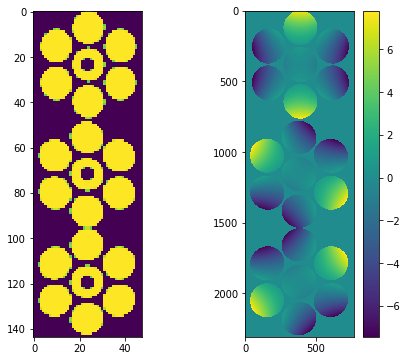

In [16]:
if simul_ActO_control == True:
    
    # Calibrate SH (valid SAs, slope null vector)
    agws_gs.reset()
    gmt.reset()
    gmt.propagate(agws_gs)
    agws_sh.calibrate(agws_gs,agws_sh_thr)
    print("Total number of valid slopes: %d"%agws_sh.n_valid_slopes)

    agws_ph_fda = agws_gs.phase.host(units='micron')
    
    if VISU == True:
        fig, (ax1,ax2) = plt.subplots(ncols=2)
        fig.set_size_inches(7,6)
        ax1.imshow(agws_sh.valid_lenslet.f.host().reshape(N_GS_PS*agws_nLenslet,agws_nLenslet)
                   , interpolation='None')
        imm = ax2.imshow(agws_ph_fda, interpolation='None')
        clb = fig.colorbar(imm)
    
    if agws_SHtype == 'diff':
        agws_sh_fov = agws_sh.pixel_scale_arcsec*agws_sh.N_PX_IMAGE/agws_sh.BIN_IMAGE

        if VISU == True:
            plt.imshow(agws_sh.flux.host(shape=(agws_nLenslet*N_GS_PS,agws_nLenslet)).T,
                       interpolation='None', origin='lower')

    print("pupil sampling: %d pixel"%agws_nPx)
    print("number of SH SAs across pupil: %d"%agws_nLenslet)
    print("number of SH pixels per SA: %d"%agws_n)
    if agws_SHtype == 'diff':
        print("SH Pixel scale: %.3farcsec"%(agws_sh.pixel_scale_arcsec))
        print("SH Field of view: %.3farcsec"%(agws_sh_fov))

In [17]:
#Compute the number of valid lenslets per SH
if simul_ActO_control == True:
    flux = agws_sh.valid_lenslet.f.host()
    flux1 = np.reshape(flux, (agws_sh.N_GS,agws_nLenslet,agws_nLenslet))

    n_subaps_all = np.zeros(agws_sh.N_GS, dtype='int')
    for kk in range(agws_sh.N_GS):
        max_flux = flux1[kk,:,:].max()
        n_subaps_all[kk] = np.sum((flux1[kk,:,:]>agws_sh_thr*max_flux) == 1)

    print("Number of subapertures per SH:")
    print(n_subaps_all)

Number of subapertures per SH:
[1136 1135 1135]


## Active Optics / Phasing control strategy in preparation for NGAO mode
The goal is to deliver a GMT configured for NGAO to close the loop.
It could be achieved in two steps:
1. Close the Active Optics loop planned for seeing-limited mode.
2. Close the phasing loop (with DFS) after Active Optics converged.

**Note** This control strategy is not properly defined anywhere.

In this strategy the DoFs that are controlled are:
1. M1 segment rigid body motions (Rx,Ry,Rz,Tx,Ty,Tz) (except M1S7 Rz and M1S7 Tz).
2. **coming soon** M2 segment rigid body motions (Rx,Ry,Rz,Tx,Ty,Tz) (except M2S7 Rz and M2S7 Tz).
3. M1 bending modes

### Calibrate (AGWS SPS - DoFs) Interaction matrices

In [18]:
if simul_ActO_control==True:
    #stroke=[100*ceo.constants.MAS2RAD, 500e-9, 100e-9]
    stroke=[0.5e-6]*3
    D2 = []
    D2.append( gmt.calibrate(ps,gsps,mirror='M1',mode='Rxyz',stroke=stroke[0]))
    D2.append( gmt.calibrate(ps,gsps,mirror='M1',mode='Txyz',stroke=stroke[1]))
    D2.append( gmt.calibrate(ps,gsps,mirror='M1',mode=u"bending modes",stroke=stroke[2]))

___ M1 ___ (Rxyz)
Segment #:1 2 3 4 5 6 7 
------------
___ M1 ___ (Txyz)
Segment #:1 2 3 4 5 6 7 
------------
___ M1 ___ (bending modes)
Segment #0: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #1: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #2: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #3: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #4: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #5: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #6: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
------------


#### Remove DoFs not desired

In [19]:
if simul_ActO_control==True:
    
    #------ Remove M1S7 Rxy from IM. Note: Rz was removed already inside gmt.calibrate() 
    #D2[0] = np.delete(D2[0], [18,19], 1)
    
    #------ Remove M1S7 Tz from IM
    #D2[1] = np.delete(D2[1],20,1)
    
    #------ Remove first Bending modes (0,1: astigmatisms)
    first_bm = 0
    if first_bm > 0:
        rem_BMastig_list = np.concatenate((np.array(range(0,gmt.M1.modes.n_mode*7,gmt.M1.modes.n_mode)),
                                       np.array(range(1,gmt.M1.modes.n_mode*7,gmt.M1.modes.n_mode))))
        D2[2] = np.delete(D2[2],rem_BMastig_list,1)
    
    #------ effective number of RBM and BM remaining
    M1_nall = (D2[2].shape)[1]
    M1_n_mode = M1_nall//7
    M1_n_rbm = (np.concatenate(D2[0:2], axis=1).shape)[1]    

#### Show the AGWS SPS - FDA Interaction Matrices 

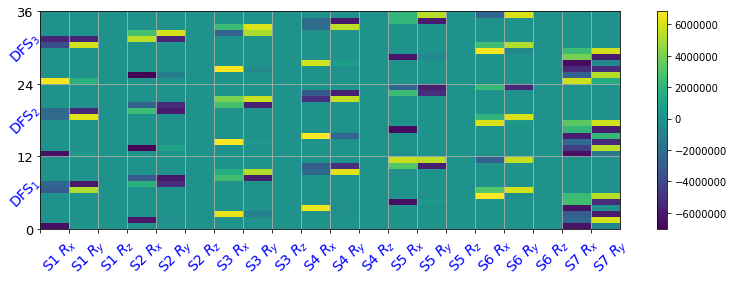

In [20]:
if  simul_ActO_control==True and VISU == True:
    fig2, ax2 = plt.subplots()
    fig2.set_size_inches(13,4)

    #Rx and Ry are in radians. We want to show IM in microns RMS SURF of tilt
    #We found using DOS that a segment tilt of 47 mas is equivalent to 0.5 microns RMS of tilt on an M1 seg.
    #AngleRadians_2_tiltcoeff = 0.5 / (47e-3*math.pi/180/3600) #angle in radians to microns RMS of tilt coeff

    imm = ax2.pcolor(D2[0])#/ceo.constants.RAD2ARCSEC)#/AngleRadians_2_tiltcoeff)  #in displaced pixels per microns RMS of M1 segment tilt
    ax2.grid()
    ax2.set_ylim([0,36])
    ax2.set_xticks(range(20))
    ax2.set_xticklabels(['S1 $R_x$','S1 $R_y$','S1 $R_z$','S2 $R_x$','S2 $R_y$','S2 $R_z$','S3 $R_x$','S3 $R_y$','S3 $R_z$',
        'S4 $R_x$','S4 $R_y$','S4 $R_z$','S5 $R_x$','S5 $R_y$','S5 $R_z$','S6 $R_x$','S6 $R_y$','S6 $R_z$','S7 $R_x$','S7 $R_y$'],
        ha='left', fontsize=14, rotation=45, color='b')
    ax2.set_yticks([0,12,24,36])
    ax2.tick_params(axis='y', labelsize=13)
    ax2.text(-0.5,6,'DFS$_1$', rotation=45, ha='center', va='center', fontsize=14, color='b')
    ax2.text(-0.5,18,'DFS$_2$', rotation=45, ha='center', va='center', fontsize=14, color='b')
    ax2.text(-0.5,30,'DFS$_3$', rotation=45, ha='center', va='center', fontsize=14, color='b')
    fig2.colorbar(imm)

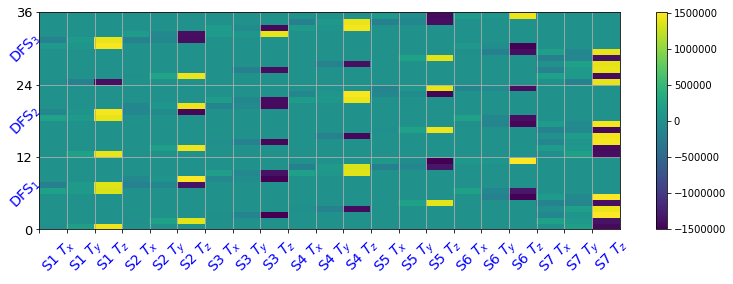

In [21]:
if  simul_ActO_control==True and VISU == True:
    fig2, ax2 = plt.subplots()
    fig2.set_size_inches(13,4)

    imm = ax2.pcolor(D2[1])
    ax2.grid()
    ax2.set_ylim([0,36])
    ax2.set_xticks(range(21))
    ax2.set_xticklabels(['S1 $T_x$','S1 $T_y$','S1 $T_z$','S2 $T_x$','S2 $T_y$','S2 $T_z$','S3 $T_x$','S3 $T_y$','S3 $T_z$',
        'S4 $T_x$','S4 $T_y$','S4 $T_z$','S5 $T_x$','S5 $T_y$','S5 $T_z$','S6 $T_x$','S6 $T_y$','S6 $T_z$','S7 $T_x$','S7 $T_y$',
        'S7 $T_z$'],
        ha='left', fontsize=14, rotation=45, color='b')
    ax2.set_yticks([0,12,24,36])
    ax2.tick_params(axis='y', labelsize=13)
    ax2.text(-0.5,6,'DFS$_1$', rotation=45, ha='center', va='center', fontsize=14, color='b')
    ax2.text(-0.5,18,'DFS$_2$', rotation=45, ha='center', va='center', fontsize=14, color='b')
    ax2.text(-0.5,30,'DFS$_3$', rotation=45, ha='center', va='center', fontsize=14, color='b')
    fig2.colorbar(imm)

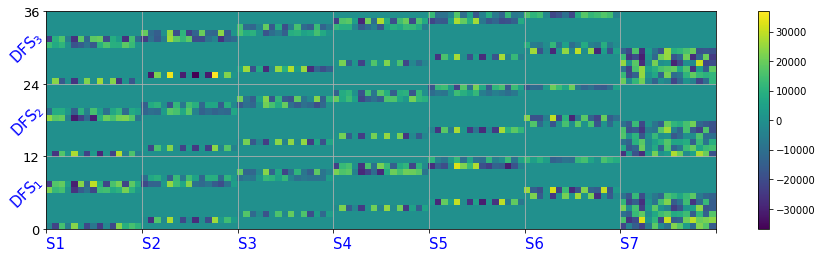

In [22]:
if  simul_ActO_control==True and VISU == True:
    fig2, ax2 = plt.subplots()
    fig2.set_size_inches(15,4)

    imm = ax2.pcolor(D2[2])
    ax2.grid()
    ax2.set_ylim([0,36])
    ax2.set_xlim([0,M1_n_mode-1])
    ax2.set_xticks(np.arange(8)*M1_n_mode)
    ax2.set_xticklabels(['S1','S2','S3','S4','S5','S6','S7'], ha='left', fontsize=15, color='b')
    ax2.set_yticks([0,12,24,36])
    ax2.tick_params(axis='y', labelsize=13)
    ax2.text(-3,6,'DFS$_1$', rotation=45, ha='center', va='center', fontsize=15, color='b')
    ax2.text(-3,18,'DFS$_2$', rotation=45, ha='center', va='center', fontsize=15, color='b')
    ax2.text(-3,30,'DFS$_3$', rotation=45, ha='center', va='center', fontsize=15, color='b')
    fig2.colorbar(imm)

#### Merge all AGWS SPS interaction matrices

AGWS SPS IM:
(36, 146)
conditioning number:
1495.111780112544


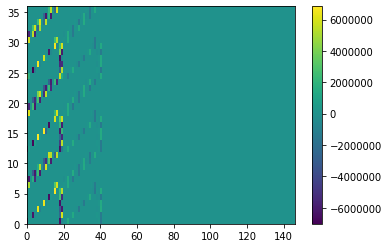

In [27]:
if simul_ActO_control==True:
    D_AGWS_SPS = np.concatenate(D2[0:3],axis=1)  # Control Rxyz, Txyz (except S7), and BM
    #D_AGWS_SPS = np.concatenate(D2[0:2],axis=1)   # Control Rxyz, and Txyz (except S7)
    #D_AGWS_SPS = D2[2]  # control only BM

    print('AGWS SPS IM:')
    print(D_AGWS_SPS.shape)
    print("conditioning number:")
    print(np.linalg.cond(D_AGWS_SPS))

    #R_AGWS_SPS = np.linalg.pinv(D_AGWS_SPS, rcond=2e-5)
    #UU2, ss2, VV2 = np.linalg.svd(D_AGWS_SPS, full_matrices=False)
    if VISU==True:
        #plt.semilogy(ss2/np.max(ss2), 'o-')
        plt.pcolor(D_AGWS_SPS)
        plt.colorbar()

### Calibrate (AGWS SH - DoFs) Interaction matrices

In [23]:
if simul_ActO_control==True:

    #stroke=[100*ceo.constants.MAS2RAD, 500e-9, 100e-9]
    stroke = [0.5e-6]*3
    D1 = []
    D1.append( gmt.calibrate(agws_sh,agws_gs,mirror='M1',mode='Rxyz',stroke=stroke[0]))
    D1.append( gmt.calibrate(agws_sh,agws_gs,mirror='M1',mode='Txyz',stroke=stroke[1]))
    D1.append( gmt.calibrate(agws_sh,agws_gs,mirror='M1',mode=u"bending modes",stroke=stroke[2]))

___ M1 ___ (Rxyz)
Segment #:1 2 3 4 5 6 7 
------------
___ M1 ___ (Txyz)
Segment #:1 2 3 4 5 6 7 
------------
___ M1 ___ (bending modes)
Segment #0: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #1: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #2: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #3: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #4: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #5: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
Segment #6: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 
------------


#### Remove DoFs not desired

In [24]:
if simul_ActO_control==True:

    #------ Remove M1S7 Rxy from IM. Note: Rz was removed already inside gmt.calibrate() 
    #D1[0] = np.delete(D1[0], [18,19], 1)
    
    #------ Remove M1S7 Tz from IM
    #D1[1] = np.delete(D1[1],20,1)
        
    #------ Remove first Bending modes (0,1: astigmatisms)
    if first_bm > 0:
        D1[2] = np.delete(D1[2],rem_BMastig_list,1)

#### Merge all AGWS SH interaction matrices

AGWS SH IM:
(6812, 146)
conditioning number:
7138328.724114819


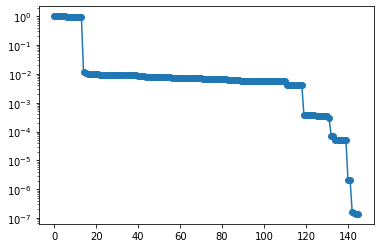

In [25]:
if simul_ActO_control==True:
    D_AGWS_SH = np.concatenate(D1[0:3],axis=1)
    #D_AGWS_SH = np.concatenate(D1[0:2],axis=1) # Control Rxyz, and Txyz (except S7)
    #D_AGWS_SH = D1[2]    # only BM
    print('AGWS SH IM:')
    print(D_AGWS_SH.shape)
    print("conditioning number:")
    print(np.linalg.cond(D_AGWS_SH))
    
    #R_AGWS_SH = np.linalg.pinv(D_AGWS_SH)#, rcond=1e-3)#2e-5)
    UU1, ss1, VV1 = np.linalg.svd(D_AGWS_SH, full_matrices=False)

    if VISU==True:
        plt.semilogy(ss1/np.max(ss1), 'o-')

### Merge AGWS SPS/SH - FDA interaction matrices
The inverse of this **merged** IM is the Active Optics/Phasing reconstructor

(6848, 146)
AGWS SPS IM Condition number: 1495.111780
AGWS SHS IM Condition number: 7138328.724115
Merged Condition number: 5217.855591


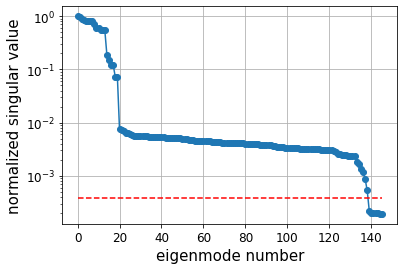

In [28]:
if simul_ActO_control==True:
    ps_norm = np.linalg.norm(D_AGWS_SPS)
    sh_norm = np.linalg.norm(D_AGWS_SH)
    D_AGWS = np.concatenate((D_AGWS_SPS/ps_norm, 
                             D_AGWS_SH/sh_norm), axis=0)
    print(D_AGWS.shape)
    
    print('AGWS SPS IM Condition number: %f'%np.linalg.cond(D_AGWS_SPS))
    print('AGWS SHS IM Condition number: %f'%np.linalg.cond(D_AGWS_SH))
    print('Merged Condition number: %f'%np.linalg.cond(D_AGWS))

    #UUos, ssos, VVos = np.linalg.svd(D_AGWS_SH, full_matrices=False)
    UU, ss, VV = np.linalg.svd(D_AGWS, full_matrices=False)
    
    # select threshold lying between last 8th and 7th eigenmodes.
    svd_thr = (ss/np.max(ss))[-8:-6].sum()/2 

    if VISU==True:
        plt.semilogy(ss/np.max(ss), 'o-')
        #plt.plot(ssos/np.max(ssos), 'rx-')
        plt.plot([0,145], [svd_thr,svd_thr], 'r--')
        plt.grid()
        plt.xlabel('eigenmode number', fontsize=15)
        plt.ylabel('normalized singular value',fontsize=15)
        plt.tick_params(labelsize=12)

In [30]:
if simul_ActO_control==True:
    R_AGWS = np.linalg.pinv(D_AGWS, rcond=svd_thr)

    #if VISU == True:
    #    plt.pcolor(D_AGWS)
    #    plt.colorbar()

#### Check the eigenmodes

In [37]:
eigenmodevec = VV[-3,:]   # SVD gives VV.T; Hence take the row, not the column vector!
#eigenmodevec = np.sum(VV[-6:,:],0)
M1RotVec = np.concatenate((eigenmodevec[ 0:20],[0])).reshape((7,3))                
M1TrVec  = eigenmodevec[20:41].reshape((7,3))
a_M1 = eigenmodevec[41:].reshape((7,-1))

gmt.reset()
gmt.M1.motion_CS.origin[:] = M1TrVec * 1e-6
gmt.M1.motion_CS.euler_angles[:] = M1RotVec * 1e-6
gmt.M1.motion_CS.update()

gmt.M1.modes.a[:,first_bm:] = np.ascontiguousarray(a_M1) *1e-6
gmt.M1.modes.update()

gs.reset()
gmt.propagate(gs)

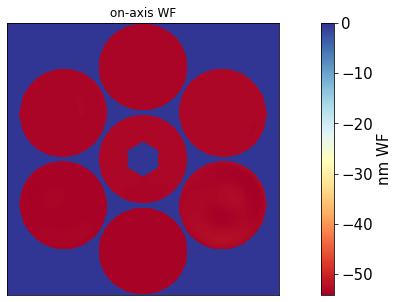

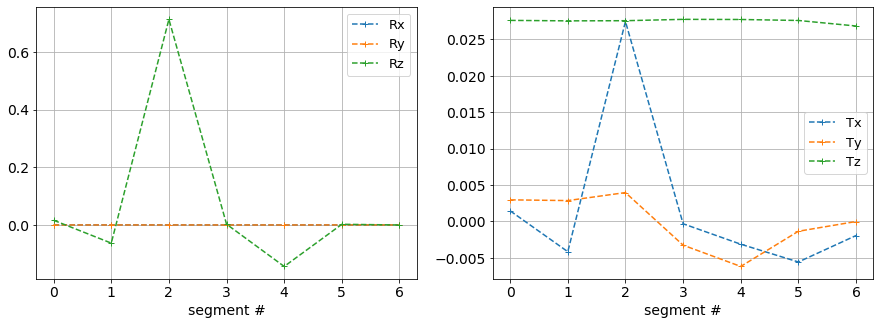

In [38]:
#------- Show resultant phase in the exit pupil
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
imm = ax.imshow(gs.phase.host(units='nm')-ph_fda_on, interpolation=None,cmap='RdYlBu', origin='lower')#, vmin=-1.5, vmax=1.5)
ax.set_title('on-axis WF')
ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
clb = fig.colorbar(imm, ax=ax)#, fraction=0.012, pad=0.03,format="%.1f")
clb.set_label('nm WF', fontsize=15)
clb.ax.tick_params(labelsize=15)

#-------- Show Rigid Body Motions
labels = ['x','y','z']
fig1, (ax1,ax2) = plt.subplots(ncols=2)
fig1.set_size_inches(15,5)

for jj in range(3):
    ax1.plot(M1RotVec[:,jj], '+--', label='R'+labels[jj])
    ax2.plot(M1TrVec[:,jj],  '+--', label='T'+labels[jj])
for thisax in (ax1,ax2):
    thisax.legend(fontsize=13)
    thisax.tick_params(labelsize=14)
    thisax.grid()
    thisax.set_xlabel('segment #', fontsize=14)

Text(0.5, 0, 'bending mode #')

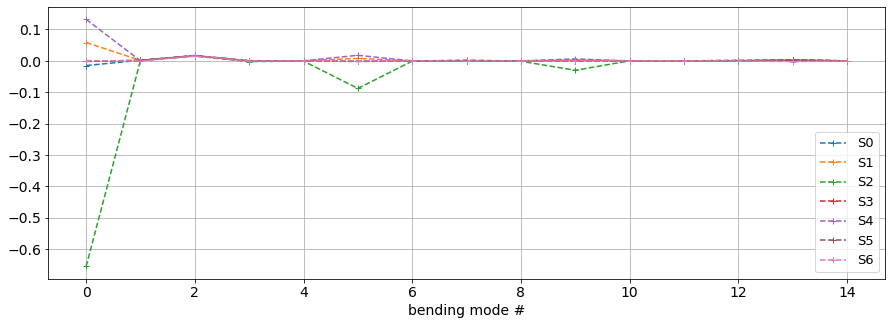

In [39]:
#---------- Show bending modes
fig2, ax3 = plt.subplots()
fig2.set_size_inches(15,5)

BMnum = np.array(range(M1_n_mode))+first_bm
for jj in range(7):
    ax3.plot(BMnum, a_M1[jj,:], '+--', label='S'+str(jj))
ax3.legend(fontsize=13)
ax3.tick_params(labelsize=14)
ax3.grid()
ax3.set_xlabel('bending mode #', fontsize=14)

## Atmospheric Turbulence initialization

In [40]:
if simul_turb==True:
    
    # Wind speed scaling for simulating tau0= [3.81, 2.60, 1.50] ms respectively
    wind_scale = [1.0, 1.4656299, 2.5404255] 
    
    zen_angle = 30  # zenith angle [deg]
    seeing = 0.63  # arcsec @ 500 nm 
    r0a  = 500e-9/(seeing*ceo.constants.ARCSEC2RAD)  # Fried parameter at zenith [m]
    r0   = r0a * np.cos(zen_angle*np.pi/180)**(3./5.)
    L0   = 25.0    # Outer scale [m]
    
    # LCO typical-typical profile
    altitude       = np.array([25, 275, 425, 1250, 4000, 8000, 13000])  # [m]
    xi0            = np.array([0.1257, 0.0874, 0.0666, 0.3498, 0.2273, 0.0681, 0.0751]) #Cn2 weights
    wind_speed     = wind_scale[0]*np.array([5.6540, 5.7964, 5.8942, 6.6370, 13.2925, 34.8250, 29.4187]) # [m/s]
    wind_direction = np.array([0.0136, 0.1441, 0.2177, 0.5672, 1.2584, 1.6266, 1.7462])  # rad

    meanV = np.sum(wind_speed**(5.0/3.0)*xi0)**(3./5.)
    tau0 = 0.314*r0/meanV
    print('       Mean wind speed : %2.1f m/s'%meanV)
    print('                  tau0 : %2.2f ms'%(tau0*1e3))
    print('    r0 @ 500nm @ %d deg: %2.1f cm'%(zen_angle,r0*1e2))
    print('seeing @ 500nm @ %d deg: %2.2f arcsec'%(zen_angle,500e-9/r0*ceo.constants.RAD2ARCSEC))

### Create the phase screen
The phase screen is saved (and restored next time that is used).
The "duration" keyword sets the maximum duration of the phase screen [in seconds]

In [52]:
if simul_turb==True:
    atm_dir = '/storage/data02/turb_phasescreens/'
    atm_fname = 'gmtAtmosphereL0-%d_r0-%1.1fcm_tau0-%1.2fms.bin'%(int(L0),r0*1e2,0.314*0.164/meanV*1e3)
    atm = ceo.Atmosphere(r0,L0,7,altitude,xi0,wind_speed,wind_direction,
                     L=26,NXY_PUPIL=346,fov=0.0*ceo.constants.ARCMIN2RAD,
                     duration=31, filename=atm_dir+atm_fname)

# Performance Evaluation Initialization

## On-axis performance evaluation

--> WF RMS on-axis: 0.76 nm wf RMS


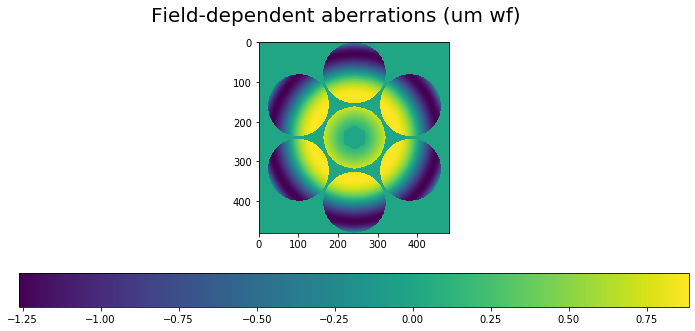

In [43]:
# Initialize on-axis star for performance evaluation
if eval_perf_onaxis==True:
    gmt.reset()
    gs.reset()
    gmt.propagate(gs)

    on_rms0 = gs.wavefront.rms()*1e9
    print('--> WF RMS on-axis: %3.2f nm wf RMS'%on_rms0)
    seg_pist_onaxis_ref = gs.piston(where='segments', units_exponent=-9)

    if VISU == True:
        fig, ax = plt.subplots()
        fig.set_size_inches(20,5)
        fig.suptitle('Field-dependent aberrations (um wf)', fontsize=20)
        imm = ax.imshow(ph_fda_on, interpolation='None')
        fig.colorbar(imm, orientation='horizontal', shrink=0.6)

    # On-axis projection of segment shapes onto Zernikes
    if eval_perf_modal==True:
        proj_radial_order= np.max( (8, gmt.M1.zernike.max_n+1, gmt.M2.zernike.max_n+1) )
        Zobj = ceo.ZernikeS(proj_radial_order)
        Zobj.fitting_init(gs)

## Segment Clocking Removal
Segment Clocking is an invisible mode to the AGWS control. We will remove this mode from time histories to better show convergence results.

In [44]:
gC_amp = 1e-5  #rad
SegClockMat = np.zeros((6*3,6))

for jj in  range(6):
    gmt.reset()
    gmt.M1.transform([0]*3,[0,0,gC_amp], segId=[jj+1])
    SegClockMat[:,jj] = np.concatenate((gmt.state['M1']['Rxyz'][0:6,1:].ravel(), gmt.state['M1']['Txyz'][0:6,0])) / gC_amp

    inv_SegClockMat = np.linalg.pinv(SegClockMat)

# Closed-loop simulation

## Initialize timing variables

In [45]:
Tsim = 1e-3                 # Simulation tick time  [s]
totSimulTime = 60e-3 * 20 + 10e-3   # Total simulated time [s]
#totSimulTime = 40e-3 * 15 + 10e-3   # Total simulated time [s]

In [46]:
#------ Active OPtics / Phasing timing and loop gains
if simul_ActO_control==True:
    sps_exptime = 10e-3        # DFS camera integration time [seconds]
    sps_sampling_time = 60e-3  # DFS sampling time [seconds]

    sps_exp_count_max = round(sps_exptime/Tsim)   
    sps_exp_delay_count_max = sps_exp_count_max*4  # number of cycles to delay exposure
    
    sps_sampl_iter = round(totSimulTime / sps_sampling_time)
    sps_sampl_count_max = round(sps_sampling_time/Tsim)  
    
    agws_spp_wait_time = 20e-3 # Time to switch off NGWS SPP control while AGWS is commanding
    agws_spp_count_max = round(agws_spp_wait_time/Tsim)
    
    wait_4_sTT = 0#5   # number of AGWS correction iterations to wait before applying M1 STT commands (i.e. FDSP compensation).
    wait_4_RBM = 0#5#10  # number of AGWS correction iterations to wait before applying other M1 RBMs
    
    #-------- Override totSimulTime
    #totSimulTime = sps_sampl_iter*sps_sampling_time + sps_exptime
    
    gAGWS = 0.6
    #gAGWS_PIST = 0.8  # to boost SPP command and get to next "zero" fringe.

### Low-pass filters for smooth AcO/Phasing commands

The LPF can be implemented as:

$a[0]*y[n] = b[0]*x[n] + b[1]*x[n-1] + ... + b[M]*x[n-M]
                       - a[1]*y[n-1] - ... - a[N]*y[n-N]$

In [47]:
if simul_ActO_control==True:
    
    #---- LPF for M1 command (slow moves)
    lpf_fc = 60  # Cut-off frequency of the filter
    lpf_w = lpf_fc / (1 / (2*Tsim)) # Normalize the frequency
    lpf_ord = 1
    lpf_b, lpf_a = signal.butter(lpf_ord, lpf_w, 'low', analog=False)

## Initial scramble

In [53]:
scramble_tt=True
scramble_pist=True
scramble_Txy = True
scramble_Rz = True
scramble_BM = True
scramble_M2_modes=False

tt_scramble_rms = 20e-3  #arcsec
pist_scramble_rms = 0.5e-6  #m 
Txy_scramble_rms = 1e-6 #m
Rz_scramble_rms = 20e-3  #arcsec
BM_scramble_rms = 2e-6
M2modes_scramble_rms = 5e-9

simul_WFPT_aber = False

VISU=True

Initial Rz scramble RMS [mas]: 20.00
Initial M1 segment TT scramble RMS [mas]: 20.00
Initial segment piston scramble RMS [micron]: 0.50
Initial segment piston scramble mean value [micron]: -0.70
Initial Txy scramble RMS [micron]: 1.00


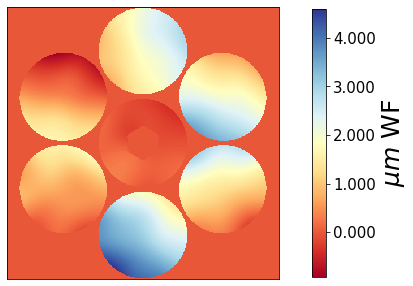

In [54]:
# Reset before starting
if simul_ActO_control==True:
    gsps.reset()

gmt.reset()
GMTstate = gmt.state

# ----------------------- Initial M1 Rz scramble ----------------------------
if scramble_Rz==True:
    Rzscramble = np.float32(np.random.normal(loc=0.0, scale=1, size=6))
    Rzscramble *= Rz_scramble_rms*ceo.constants.ARCSEC2RAD/np.std(Rzscramble)
    #Rzscramble -= np.mean(Rzscramble)
    GMTstate['M1']['Rxyz'][0:6,2] += Rzscramble
    print("Initial Rz scramble RMS [mas]: %0.2f"%(np.std(Rzscramble)*ceo.constants.RAD2MAS))
    
    
# ---------------------- Initial M1 Segment TT Scramble -----------------------
if scramble_tt==True:
    TTscramble = np.float32(np.random.normal(loc=0.0, scale=1, size=14))
    if simul_ActO_control==True: TTscramble[12:] = 0
    TTscramble *= tt_scramble_rms*ceo.constants.ARCSEC2RAD/np.std(TTscramble)
    #TTscramble -= np.mean(TTscramble)
    
    GMTstate['M1']['Rxyz'][:,0:2] += TTscramble.reshape((7,2))
    print("Initial M1 segment TT scramble RMS [mas]: %0.2f"%(np.std(TTscramble)*ceo.constants.RAD2MAS))
    #print("Initial M1 segment TT scramble mean value [mas]: %0.2f"%(np.mean(TTscramble)*ceo.constants.RAD2MAS))

    
# ---------------------- Initial M1 Segment Piston Scramble ---------------------
if scramble_pist==True:
    pistscramble  = np.float32(np.random.normal(loc=0.0, scale=1, size=7))
    pistscramble *= pist_scramble_rms/np.std(pistscramble)
    pistscramble -= np.mean(pistscramble)
    pistscramble -= pistscramble[6]
    
    GMTstate['M1']['Txyz'][:,2] += pistscramble
    print("Initial segment piston scramble RMS [micron]: %0.2f"%(np.std(pistscramble)*1e6))
    print("Initial segment piston scramble mean value [micron]: %0.2f"%(np.mean(pistscramble)*1e6))

    
# ---------------------- Initial M1 Segment Translations Txy Scramble ----------
if scramble_Txy==True:
    Txyscramble  = np.float32(np.random.normal(loc=0.0, scale=1, size=14))
    Txyscramble *= Txy_scramble_rms/np.std(Txyscramble)
    Txyscramble -= np.mean(Txyscramble)
    
    GMTstate['M1']['Txyz'][:,0:2] += Txyscramble.reshape((7,2))
    print("Initial Txy scramble RMS [micron]: %0.2f"%(np.std(Txyscramble)*1e6))
    #print("Initial Txy scramble mean value [micron]: %0.2f"%(np.mean(Txyscramble)*1e6))

    
# ---------------------- Initial M1 bending modes scramble ---------------------    
if scramble_BM==True:
    
    """BM_scramble_rms = [  5.25217646e-05,   5.48182586e-05,   3.26740817e-05,
         4.55026306e-06,   5.04276142e-06,   7.80775398e-06,
         7.63018746e-06,   2.33925734e-06,   2.30900017e-06,
         3.19587738e-06,   2.94658844e-06,   1.02543169e-06,
         1.07363214e-06,   3.83340551e-06,   5.68972554e-07,
         9.46179841e-07,   9.18616441e-07,   8.32369343e-07,
         1.91625430e-06,   1.82604436e-06,   5.37559150e-07,
         4.86967403e-07,   6.29756064e-07,   7.58545955e-07,
         9.38404328e-07,   1.04286499e-06,   2.07234823e-06,
         5.49838858e-07,   3.94058648e-07,   4.85664215e-07,
         4.06708712e-07,   4.08315307e-07,   4.17178252e-07,
         3.52245098e-07,   5.47804423e-07,   6.61446978e-07,
         3.29434349e-07,   2.16312478e-07,   4.35262422e-07,
         2.29168284e-07,   3.12997452e-07,   2.39556335e-07]
    
    for j in range(M1_n_modes):
        BMscramble1 = np.float32(np.random.normal(loc=0.0, scale=1, size=7))
        #BMscramble1 *= BM_scramble_rms[j+first_bm] /np.std(BMscramble1)
        BMscramble1 *= BM_scramble_rms[j] /np.std(BMscramble1) 
        #gmt.M1.modes.a[:,j+first_bm] += BMscramble1
        gmt.M1.modes.a[:,j] += BMscramble1
    BMscramble = np.copy(gmt.M1.modes.a[:])"""
    
    BMscramble  = np.float32(np.random.normal(loc=0.0, scale=1, size=M1_n_modes*7))
    BMscramble *= BM_scramble_rms/np.std(BMscramble)
    GMTstate['M1']['modes'] += BMscramble.reshape((7,-1))

    
# ---------------------- Initial M2 modes scramble ---------------------      
if scramble_M2_modes==True:
    M2modes_scramble = np.random.normal(loc=0.0, scale=1, size=(7,ao_n_mode))
    M2modes_scramble *= M2modes_scramble_rms/np.std(M2modes_scramble)
    M2modes_scramble[:,0] = 0

    #--- If you wanted to introduce just one mode over one segment....
    #M2modes_scramble = np.zeros((7,ao_n_mode))
    #M2modes_scramble[0,100] = 50e-9
    #M2modes_scramble[1,1] = 50e-9
    #M2modes_scramble[2,5] = 100e-9
    #M2modes_scramble[3,10] = 60e-9

    GMTstate['M2']['modes'][:,z_first_mode:] += M2modes_scramble
    
    
# ----------------------- Update the GMT with Initial Scramble
gmt^=GMTstate


if eval_perf_onaxis==True and VISU==True:
    gs.reset()
    gmt.propagate(gs)
    fig, ax = plt.subplots()
    fig.set_size_inches(20,5)
    InitScr = gs.phase.host(units='micron')-ph_fda_on*1e-3
    imm = ax.imshow(InitScr, interpolation='None',cmap='RdYlBu',origin='lower')
    ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    clb = fig.colorbar(imm, ax=ax, fraction=0.012, pad=0.03,format="%.3f")
    clb.set_label('$\mu m$ WF', fontsize=25)
    #clb.set_label('nm WF', fontsize=25)
    clb.ax.tick_params(labelsize=15)
    #gs.reset()
    #plt.text(nPx/12,nPx*5/6,'M1S1 $R_x$', color='b', fontsize=15)

### Allocate memory for telemetry

In [55]:
totSimulIter = round(totSimulTime/Tsim)
timeVec = np.arange(totSimulIter)*Tsim

if simul_ActO_control==True:
    kk = 1           # to keep the count of AGWS commands applied.
    sps_exp_count = 0
    sps_exp_delay_count = 0
    sps_sampl_count = 0
    agws_spp_count = 0  # to switch off NGWS SPP control while AGWS is commanding
    timeCorVec = np.arange(sps_sampl_iter+1)*sps_sampling_time

    #ps.camera.reset_rng(sps_seed)

    if eval_perf_sps==True:
        seg_pist_sps_iter = np.zeros((N_GS_PS,7,totSimulIter))

    SPSmeas_iter = np.zeros((N_GS_PS*12,sps_sampl_iter+1))
    SPSfft_images = np.zeros((ps.camera.N_PX_IMAGE,ps.camera.N_PX_IMAGE,N_GS_PS*12,sps_sampl_iter+1))

    #--- Telemetry
    M1RotVecIter = np.zeros((7,3,totSimulIter))
    M1TrVecIter  = np.zeros((7,3,totSimulIter))
    a_M1_iter = np.zeros((7,M1_n_modes,totSimulIter))
    M1RotVecIter_gCr = np.zeros((7,3,totSimulIter))
    M1TrVecIter_gCr  = np.zeros((7,3,totSimulIter))
    
    #--- Command updates
    M1RotVec = np.zeros((7,3))
    M1TrVec  = np.zeros((7,3)) 
    a_M1  = np.zeros((7,M1_n_modes))
    
    M1RotVec_in  = np.zeros((7,3,lpf_ord+1))  # buffer of M1 rotations    (input of LPF)
    M1TrVec_in   = np.zeros((7,3,lpf_ord+1))  # buffer of M1 translations (input of LPF)
    M1RotVec_out = np.zeros((7,3,lpf_ord+1))  # buffer of M1 rotations    (output of LPF)
    M1TrVec_out  = np.zeros((7,3,lpf_ord+1))  # buffer of M1 translations (output of LPF)
    a_M1_in      = np.zeros((7,M1_n_modes,lpf_ord+1)) # buffer of M1 bending modes (input of LPF)
    a_M1_out     = np.zeros((7,M1_n_modes,lpf_ord+1)) # buffer of M1 bending modes (output of LPF)
    
    agws_slopes_iter = np.zeros((agws_sh.n_valid_slopes,sps_sampl_iter+1))
    

if eval_perf_onaxis==True:
    wfe_gs_iter      = np.zeros(totSimulIter)
    seg_pist_onaxis_iter  = np.zeros((7,totSimulIter)) #spp_gs_iter
    seg_wfe_onaxis_iter   = np.zeros((7,totSimulIter)) #seg_wfe_gs_iter
    if simul_turb==True:
        wfe_gs_tur_iter = np.zeros(totSimulIter)
    if eval_perf_modal==True:
        seg_aRes_gs_iter = np.zeros((Zobj.n_mode,7,totSimulIter))
        if simul_turb==True:
            seg_aTur_gs_iter = np.zeros((Zobj.n_mode,7,totSimulIter))

elapsedTime = np.zeros(totSimulIter)

print('Simulation time step [ms]: %4.2f'%(Tsim*1e3))
print('Total simulation time [s]: %4.3f'%(totSimulTime))
if simul_ActO_control==True:
    print('  DFS Sampling time  [ms]: %4.2f'%(sps_sampling_time*1e3))
    print('  DFS Exposure time  [ms]: %4.2f'%(sps_exptime*1e3))

Simulation time step [ms]: 1.00
Total simulation time [s]: 1.210
  DFS Sampling time  [ms]: 60.00
  DFS Exposure time  [ms]: 10.00


## Run the simulation!!!!

In [56]:
VISU=False

if simul_ActO_control==True:
    ps.reset()
    agws_sh.reset()

if VISU == True:
    f, (ax1,ax2) = plt.subplots(2,1)
    f.set_size_inches(15,10)

    
#------------ Start the control loops ------------------------------------
for jj in range(totSimulIter):
    #print("\nElapsed time:%3.3f"%((jj+1)*Tsim))
    tid.tic()
    if eval_perf_onaxis==True:
        gs.reset()
        
        #--- add on-axis WF
        if simul_WFPT_aber==True:
            gs.wavefront.axpy(1,cuFloatArray(host_data=wfpt_onaxis_aber))

    if simul_ActO_control==True:
        gsps.reset()
        agws_gs.reset()
        
        #--- add WF to DFS and SH
        if simul_WFPT_aber==True:
            gsps.wavefront.axpy(   1,cuFloatArray(host_data=wfpt_offaxis_aber))
            agws_gs.wavefront.axpy(1,cuFloatArray(host_data=wfpt_offaxis_aber))    
        
    #----- Update Turbulence --------------------------------------------
    if simul_turb == True:
        if simul_ActO_control==True:
            atm.ray_tracing(gsps, sps_p, sps_nPx, sps_p, sps_nPx, jj*Tsim)
            atm.ray_tracing(agws_gs, agws_p, nPx1, agws_p, nPx1, jj*Tsim)

            
    #---- Update GMT state -------------------------------------------
    gmt^=GMTstate            
    
            
    #----- ACTIVE OPTICS CORRECTION -------------------------------
    #      Update M1 Rigid Body Motions, and M1 bending modes
    if simul_ActO_control==True:
        
        #-- Low-pass filter AcO/Phasing commands
        M1TrVec_in   = np.roll(M1TrVec_in,1)
        M1TrVec_out  = np.roll(M1TrVec_out,1)
        M1RotVec_in  = np.roll(M1RotVec_in,1)
        M1RotVec_out = np.roll(M1RotVec_out,1)
        a_M1_in      = np.roll(a_M1_in,1)
        a_M1_out     = np.roll(a_M1_out,1)
        

        M1TrVec_in[:,:,0]  = M1TrVec
        M1RotVec_in[:,:,0] = M1RotVec
        a_M1_in[:,:,0]       = a_M1
        M1TrVec_out[:,:,0]  = lpf_b[0]*M1TrVec_in[:,:,0]  + lpf_b[1]*M1TrVec_in[:,:,1]  - lpf_a[1]*M1TrVec_out[:,:,1]
        M1RotVec_out[:,:,0] = lpf_b[0]*M1RotVec_in[:,:,0] + lpf_b[1]*M1RotVec_in[:,:,1] - lpf_a[1]*M1RotVec_out[:,:,1]
        a_M1_out[:,:,0]     = lpf_b[0]*a_M1_in[:,:,0]     + lpf_b[1]*a_M1_in[:,:,1] - lpf_a[1]*a_M1_out[:,:,1]
       
        GMTstate['M1']['Txyz'] -= (M1TrVec_out[:,:,0] - M1TrVec_out[:,:,1] )
        GMTstate['M1']['Rxyz'] -= (M1RotVec_out[:,:,0] - M1RotVec_out[:,:,1])
        GMTstate['M1']['modes'][:,first_bm:] -= (a_M1_out[:,:,0] - a_M1_out[:,:,1])

        M1RotVecIter[:,:,jj] = gmt.M1.motion_CS.euler_angles[:]
        M1TrVecIter[:,:,jj]  = gmt.M1.motion_CS.origin[:]
        a_M1_iter[:,:,jj]    = gmt.M1.modes.a[:] 
        
        # Remove segment clocking from time histories
        segCl_rem = np.dot(SegClockMat, np.dot(inv_SegClockMat, np.concatenate((M1RotVecIter[0:6,1:,jj].ravel(), M1TrVecIter[0:6,0,jj]))))
        M1RotVecIter_gCr[:,:,jj] = M1RotVecIter[:,:,jj]
        M1RotVecIter_gCr[0:6,1:,jj] -= segCl_rem[0:12].reshape((6,2))
        M1TrVecIter_gCr[:,:,jj]  = M1TrVecIter[:,:,jj]
        M1TrVecIter_gCr[0:6,0,jj] -= segCl_rem[12:]        
        
    
    #----- Performance evaluation ---------------------------------
    if eval_perf_onaxis==True:
        gmt.propagate(gs)
        wfe_gs_iter[jj] = gs.wavefront.rms()
        seg_pist_onaxis_iter[:,jj] = gs.piston(where='segments', units_exponent=-9) - seg_pist_onaxis_ref
        seg_wfe_onaxis_iter[:,jj] = gs.phaseRms(where='segments', units_exponent=-9)

        if eval_perf_modal==True:
            PhaseRes = gs.phase.host(units='nm')-ph_fda_on
            seg_aRes_gs_iter[:,:,jj] = Zobj.fitting(PhaseRes)

    if simul_ActO_control==True:
        gmt.propagate(gsps)
        if eval_perf_sps==True:
            seg_pist_sps_iter[:,:,jj] = gsps.piston(where='segments', units_exponent=-9) - seg_pist_sps_ref


    #----- AGWS SH and SPS integration --------------------
    if simul_ActO_control==True:
        if sps_exp_delay_count < sps_exp_delay_count_max:
            sps_exp_delay_count += 1
            SPS_CAN_READOUT=False
            #print("AGWS SH/SPS exposure avoided at %3.1f ms"%((jj+1)*Tsim*1e3))
        else:             
            ps.propagate(gsps)
            SPS_CAN_READOUT = True
            gmt.propagate(agws_gs)
            agws_sh.propagate(agws_gs)
            #print("AGWS SH/SPS exposure done at %3.1f ms"%((jj+1)*Tsim*1e3))

        #----- visualization ---------------------------------
        if VISU == True:
            if jj > 0: clb.remove()
            h = ax1.imshow(gs.phase.host(units='micron')-ph_fda_on*1e-3,interpolation='None')#, clim=(-1.8,1.8))
            ax1.set_title(jj, fontsize=20)
            clb = f.colorbar(h, ax=ax1, shrink=0.8)
            clb.set_label('um')
            if jj > 0: clb2.remove()
            Pmask = gsps.wavefront.amplitude.host().reshape((sps_nPx*N_GS_PS,sps_nPx)).T
            h2 = ax2.imshow((gsps.phase.host(units='micron').T-ph_fda)*Pmask,interpolation='None')#, clim=(-1,1))
            ax2.set_title(jj, fontsize=20)
            clb2 = f.colorbar(h2, ax=ax2, shrink=0.8)
            clb2.set_label('um')
            IPython.display.clear_output(wait=True)
            IPython.display.display(f)            

        #----- SPS: Read out, compute FFT imagette and accumulate ------
        if sps_exp_count == sps_exp_count_max-1:
            
            if SPS_CAN_READOUT==True: 
                #--- Read-out the detector
                if sps_simul_phot==True:
                    ps.camera.readOut(sps_exptime,sps_RONval,sps_tot_bkgd_noise,sps_excess_noise)
                #--- Compute and integrate FFTlet images:
                ps.fft()
                #print("\n SPS exposure completed at %3.1f ms"%((jj+1)*Tsim*1e3))                
                
            ps.camera.reset()
            sps_exp_count = 0
        else: sps_exp_count += 1

        #--- Compute AGWS SH and SPS signals and Active Optics/Phasing commands:
        if sps_sampl_count == sps_sampl_count_max-1:
            #print("\nSending a command at %3.1f ms"%((jj+1)*Tsim*1e3))

            #-- Compute SPS signals
            ps.process()
            SPSmeas = ps.get_measurement()
            SPSfft_images[:,:,:,kk] = ps.get_data_cube(data_type='fftlet')
            SPSmeas_iter[:,kk] = SPSmeas

            #-- Compute SH slopes:
            agws_sh.process()
            agws_slopevec = agws_sh.get_measurement()
            agws_slopes_iter[:,kk] = agws_slopevec
            
            #------------------------------------------------------------------------
            #-- Compute Active Optics / Phasing commands
            AGWSmeas = np.concatenate((SPSmeas/ps_norm, agws_slopevec/sh_norm))
            myActOptest1 = np.dot(R_AGWS,AGWSmeas)

            ## - When controlling M1 6 rigid body motions + bending modes
            #TrVecTemp  = np.concatenate((myActOptest1[20:40],[0])).reshape((7,3))
            TrVecTemp  = myActOptest1[20:41].reshape((7,3))
            RotVecTemp = np.concatenate((myActOptest1[ 0:20],[0])).reshape((7,3))
            M1TrVec  += gAGWS * TrVecTemp
            M1RotVec += gAGWS * RotVecTemp
            a_M1     += gAGWS * myActOptest1[41:].reshape((7,-1))

            ## - When controlling only M1 bending modes
            #a_M1 += gAGWS * myActOptest1.reshape((7,-1))
            
            ## - When controlling only M1 segment piston and TT
            #M1TrVec[0:6,2]  += myActOptest1[14:]
            #M1RotVec[:,0:2] += myActOptest1[0:14].reshape((7,2))
            
            ## - When controlling only M1 segment piston and TT (except S7)
            #M2KL0           += gAGWS_PIST * myActOptest1[14:]
            #M1RotVec[:,0:2] += gAGWS      * myActOptest1[0:14].reshape((7,2)) 
            ##M1RotVec[0:6,0:2] += gAGWS * myActOptest1[0:12].reshape((6,2))  When not controlling S7 Rxy
            
            ## - When controlling only M1 6 rigid body motions
            #TrVecTemp  = np.concatenate((myActOptest1[20:40],[0])).reshape((7,3))
            #RotVecTemp = np.concatenate((myActOptest1[ 0:20],[0])).reshape((7,3))
            #M1TrVec[:,0:2] += gAGWS * TrVecTemp[:,0:2]
            #M2KL0    += gAGWS_PIST * TrVecTemp[0:6,2]
            #M1RotVec += gAGWS * RotVecTemp
            

            #--- Wait to apply M1 Rigid Body Motions, M1 bending modes, ...
            if kk<wait_4_sTT:
                M1RotVec[:,0:2] *= 0 # wait to apply M1 Rxy commands
            if kk<wait_4_RBM:
                M1TrVec[:,0:2] *= 0  # wait to apply M1 Txy commands
                M1RotVec[:,2]  *= 0  # wait to apply M1 Rz commands
                a_M1 *= 0            # wait to apply M1 bending modes commands


            AGWS_SPP_M2_COMMAND = True
            print("SPP AGWS turn")
            #--- Reset AGWS sensors
            ps.fftlet.reset()
            agws_sh.reset()

            #sys.stdout.write("\nseg piston RMS [microns]: %0.3f\n"%(np.std(M1PSresiter[:,kk])*1e6))

            kk += 1
            sps_sampl_count = 0
            sps_exp_delay_count = 0
            #print("SPS command applied at %3.1f ms"%((jj+1)*Tsim*1e3))

        else: sps_sampl_count += 1            

    tid.toc()
    elapsedTime[jj] = tid.elapsedTime
    #sys.stdout.write("\r iter: %d/%d, ET: %.2f, seg piston [nm WF RMS] on-axis: %0.1f"%(jj, totSimulIter, tid.elapsedTime, np.std(seg_pist_onaxis_iter[:,jj])))
    sys.stdout.write("\r iter: %d/%d, ET: %.2f, WFE [nm WF RMS] on-axis: %0.1f"%(jj, totSimulIter, tid.elapsedTime, wfe_gs_iter[jj]*1e9))
    sys.stdout.flush()   
    
if VISU == True:
    clb.remove()
    h = ax1.imshow(gs.phase.host(units='micron')-ph_fda_on*1e-3,interpolation='None')
    ax1.set_title(jj, fontsize=20)
    clb = f.colorbar(h, ax=ax1, shrink=0.8)
    clb2.remove()
    Pmask = gsps.wavefront.amplitude.host().reshape((sps_nPx*N_GS_PS,sps_nPx)).T
    h2 = ax2.imshow((gsps.phase.host(units='micron').T-ph_fda)*Pmask,interpolation='None')
    ax2.set_title(jj, fontsize=20)
    clb2 = f.colorbar(h2, ax=ax2, shrink=0.8)
    clb2.set_label('um')
    IPython.display.clear_output(wait=True)
    IPython.display.display(f)
    plt.close()

 iter: 58/1210, ET: 75.60, WFE [nm WF RMS] on-axis: 1127.7SPP AGWS turn
 iter: 118/1210, ET: 78.26, WFE [nm WF RMS] on-axis: 434.67SPP AGWS turn
 iter: 178/1210, ET: 75.94, WFE [nm WF RMS] on-axis: 175.56SPP AGWS turn
 iter: 238/1210, ET: 76.40, WFE [nm WF RMS] on-axis: 65.825SPP AGWS turn
 iter: 298/1210, ET: 76.67, WFE [nm WF RMS] on-axis: 24.28SPP AGWS turn
 iter: 358/1210, ET: 74.94, WFE [nm WF RMS] on-axis: 9.102SPP AGWS turn
 iter: 418/1210, ET: 78.04, WFE [nm WF RMS] on-axis: 3.51SPP AGWS turn
 iter: 478/1210, ET: 78.67, WFE [nm WF RMS] on-axis: 1.75SPP AGWS turn
 iter: 538/1210, ET: 78.17, WFE [nm WF RMS] on-axis: 1.07SPP AGWS turn
 iter: 598/1210, ET: 76.90, WFE [nm WF RMS] on-axis: 1.10SPP AGWS turn
 iter: 658/1210, ET: 77.48, WFE [nm WF RMS] on-axis: 1.11SPP AGWS turn
 iter: 718/1210, ET: 78.06, WFE [nm WF RMS] on-axis: 1.01SPP AGWS turn
 iter: 778/1210, ET: 75.96, WFE [nm WF RMS] on-axis: 1.20SPP AGWS turn
 iter: 838/1210, ET: 74.54, WFE [nm WF RMS] on-axis: 0.82SPP AGWS tu

# Preview simulation results

In [58]:
VISU=True
    
if simul_ActO_control==True:   
    #-- Ticks will be set at multiples of AGWS sampling Time
    xticksrange = np.round(np.array([0,timeVec[-1]]) / sps_sampling_time)
    agws_ticks = np.arange(xticksrange[0],xticksrange[1]+1)*sps_sampling_time*1e3


## Show final on-axis residual WF

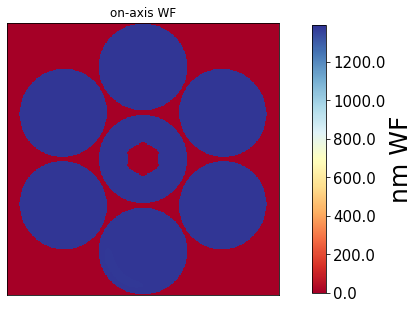

In [59]:
if VISU == True:
    #gs.reset()
    #gmt.propagate(gs)
    fig, ax = plt.subplots()
    fig.set_size_inches(20,5)
    imm = ax.imshow(gs.phase.host(units='nm')-ph_fda_on, interpolation='None',cmap='RdYlBu', origin='lower')#, vmin=-1.5, vmax=1.5)
    ax.set_title('on-axis WF')
    ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
    clb = fig.colorbar(imm, ax=ax, fraction=0.012, pad=0.03,format="%.1f")
    clb.set_label('nm WF', fontsize=25)
    clb.ax.tick_params(labelsize=15)

## on-axis WFE vs. iteration number

Final WFE [nm RMS]: 5.9
Equivalent SR in K band: 0.9997


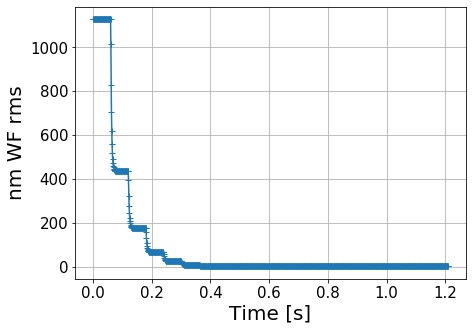

In [60]:
if VISU == True and eval_perf_onaxis==True:
    fig, ax = plt.subplots()
    fig.set_size_inches(7,5)
    ax.plot(timeVec, wfe_gs_iter*1e9, '-+')
    ax.grid()
    ax.set_xlabel('Time [s]', fontsize=20)
    ax.set_ylabel('nm WF rms', fontsize=20)
    ax.tick_params(labelsize=15)
    #ax.set_ylim([0,10000])
    wfe_final = np.mean(wfe_gs_iter[200:])
    print('Final WFE [nm RMS]: %3.1f'%(wfe_final*1e9))
    print('Equivalent SR in K band: %1.4f'%(np.exp(-(wfe_final*2*np.pi/2.2e-6)**2)))

## on-axis segment WFE vs. iteration number

Final WFE [nm RMS]: 3.8
Equivalent SR in K band: 0.9999


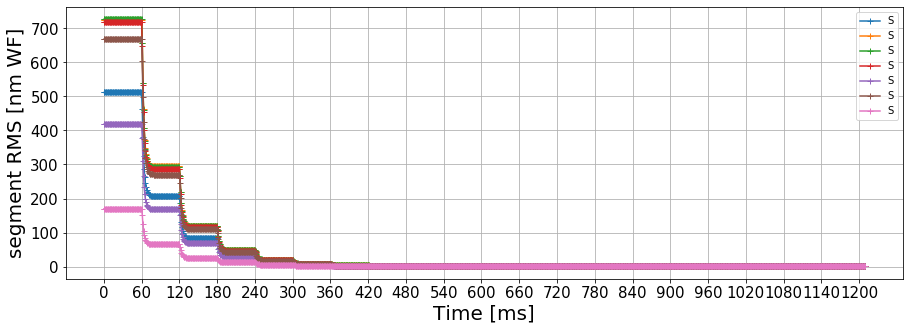

In [61]:
if VISU == True and eval_perf_onaxis==True:
    fig, ax = plt.subplots()
    fig.set_size_inches(15,5)
    ax.plot(timeVec*1e3, seg_wfe_onaxis_iter.T, '-+', label='S')
    ax.grid()
    ax.set_xlabel('Time [ms]', fontsize=20)
    ax.set_ylabel('segment RMS [nm WF]', fontsize=20)
    ax.tick_params(labelsize=15)
    ax.set_xticks(agws_ticks) # xTicks will be set at multiples of AGWS sampling Time

    ax.legend()
    #ax.set_ylim([0,10000])
    
    wfe_final = np.mean(seg_wfe_onaxis_iter[:,200:])
    print ('Final WFE [nm RMS]: %3.1f'%(wfe_final))
    print ('Equivalent SR in K band: %1.4f'%(np.exp(-(wfe_final*2*np.pi/2200.0)**2)))

## on-axis segment Piston vs. iteration number

seg piston [nm WF RMS] on-axis: 0.5


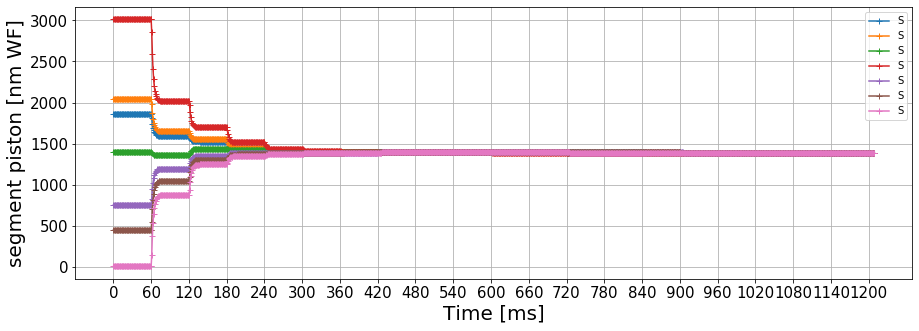

In [63]:
if VISU == True and eval_perf_onaxis==True:
    fig, ax = plt.subplots()
    fig.set_size_inches(15,5)
    ax.plot(timeVec*1e3, seg_pist_onaxis_iter.T, '-+', label='S')
    ax.grid()
    ax.set_xlabel('Time [ms]', fontsize=20)
    ax.set_ylabel('segment piston [nm WF]', fontsize=20)
    ax.tick_params(labelsize=15)
    ax.legend()
    ax.set_xticks(agws_ticks) # xTicks will be set at multiples of AGWS sampling Time
    
    #ax.set_ylim([-10000,10000])
    
    print("seg piston [nm WF RMS] on-axis: %0.1f"%(np.std(seg_pist_onaxis_iter[:,-1])))

## M1 and M2 commands history

### Segment piston (Tz) analysis

Final M1 final piston (Tz) values [nm WF]:
[-1432.254 -1443.314 -1437.871 -1418.785 -1439.788 -1441.56  -1398.748]
-----
Final M2 final piston (Tz) values [nm WF]:
[0. 0. 0. 0. 0. 0. 0.]


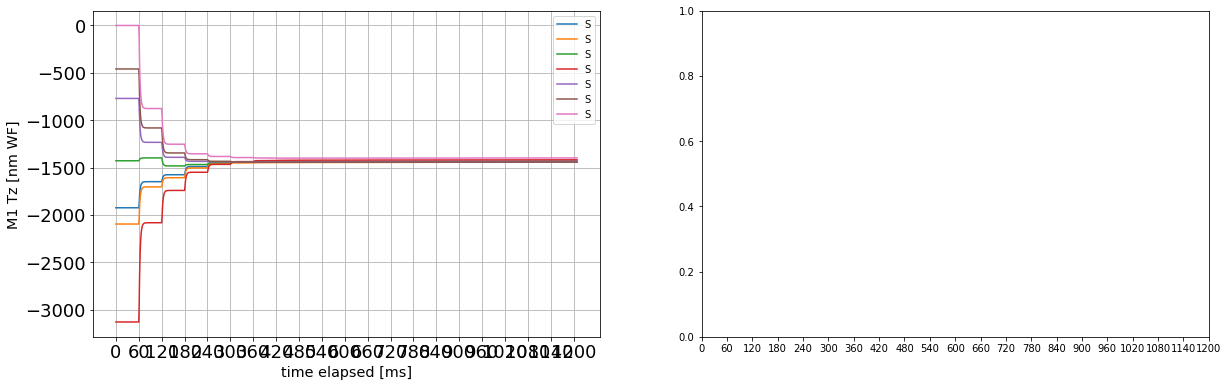

In [65]:
print('Final M1 final piston (Tz) values [nm WF]:')
print(np.array_str(gmt.M1.motion_CS.origin[:,2]*1e9*2, precision=3, suppress_small=True))
print('-----')
print('Final M2 final piston (Tz) values [nm WF]:')
print(np.array_str(gmt.M2.motion_CS.origin[:,2]*1e9*2, precision=3, suppress_small=True))


if VISU == True:
    f1, (ax1,ax2) = plt.subplots(ncols=2)
    f1.set_size_inches(20,6)

    if simul_ActO_control==True:
        ax1.plot(timeVec*1e3, M1TrVecIter[:,2,:].T*1e9*2, label='S')
        ax1.grid()
        #ax1.set_title('Tz', size='x-large')
        ax1.set_xlabel('time elapsed [ms]', size='x-large')
        ax1.set_ylabel('M1 Tz [nm WF]', size='x-large')
        ax1.tick_params(labelsize=18)
        ax1.legend()  
        #ax1.set_ylim([-5000,5000])
    elif scramble_pist==True:
        ax1.plot(np.array([0, np.max(timeVec)*1e3]), np.array([pistscramble,pistscramble])*1e9*2)
        ax1.grid()
        ax1.set_xlabel('elapsed time [ms]',size='x-large')
        ax1.set_ylabel('M1 segment piston [nm WF]', size='x-large')
        ax1.tick_params(labelsize=18)
    ax1.set_xticks(agws_ticks) # xTicks will be set at multiples of AGWS sampling Time


    """    if simul_ActO_control==True:
        ax2.plot(timeCorVec, M2TrVecIter[:,2,:].T*1e9*2, label='S', drawstyle='steps-post')
        ax2.grid()
        #ax2.set_title('Tz', size='x-large')
        ax2.set_xlabel('time elapsed [s]', size='x-large')
        ax2.set_ylabel('M2 Tz [nm WF]', size='x-large')
        ax2.tick_params(labelsize=18)
        #ax2.legend()"""
        

    ax2.set_xticks(agws_ticks) # xTicks will be set at multiples of AGWS sampling Time


### Segment Rotations (Rx Ry) analysis

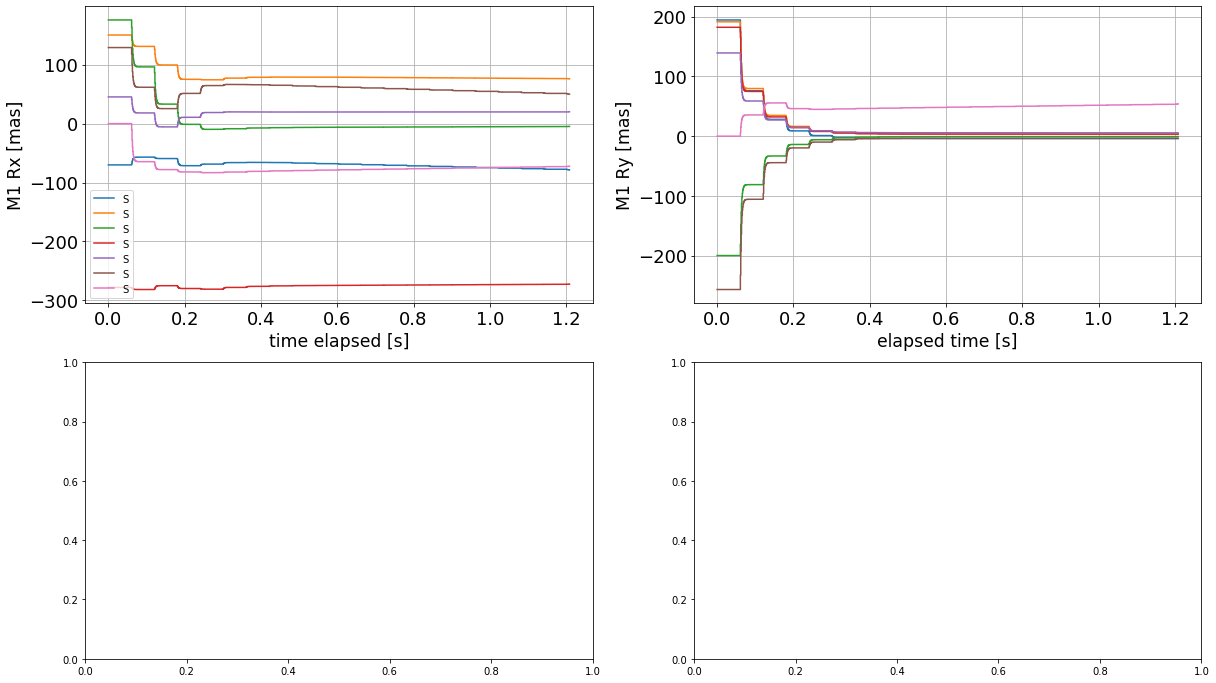

In [68]:
if VISU == True:
    f1, ((ax3,ax4), (ax7,ax8)) = plt.subplots(2,2)
    f1.set_size_inches(20,12)
    
    if simul_ActO_control==True:

        #ax3.axis('auto')
        #ax4.axis('auto')
        #ax5.axis('auto')
        #ax6.axis('auto')
        #ax7.axis('auto')
        #ax8.axis('auto')

        
        ax3.plot(timeVec, M1RotVecIter[:,0,:].T*ceo.constants.RAD2MAS*8, label='S', drawstyle='steps-post')
        ax3.grid()
        ax3.set_xlabel('time elapsed [s]', size='xx-large')
        ax3.set_ylabel('M1 Rx [mas]', size='xx-large')
        ax3.tick_params(labelsize=18)
        ax3.legend()
        #ax3.set_ylim([-2e3,2e3])
        #ax3.set_xlim([0,np.max(timeVec)])

        ax4.plot(timeVec, M1RotVecIter_gCr[:,1,:].T *ceo.constants.RAD2MAS*8, drawstyle='steps-post')
        ax4.grid()
        ax4.set_xlabel('elapsed time [s]', size='xx-large')
        ax4.set_ylabel('M1 Ry [mas]', size='xx-large')
        ax4.tick_params(labelsize=18)
    #    ax4.set_xlim([0,60])
        #ax4.set_ylim([-2e3,2e3])
        #ax4.set_xlim([0,np.max(timeVec)])
    
        """ax5.plot(timeCorVec, M2RotVecIter[:,0,:].T*ceo.constants.RAD2MAS, label='S', drawstyle='steps-post')
        ax5.grid()
        ax5.set_xlabel('time elapsed [s]', size='xx-large')
        ax5.set_ylabel('M2 Rx [mas]', size='xx-large')
        ax5.tick_params(labelsize=18)
        #ax5.legend() 

        ax6.plot(timeCorVec, M2RotVecIter[:,1,:].T *ceo.constants.RAD2MAS, drawstyle='steps-post')
        ax6.grid()
        ax6.set_xlabel('elapsed time [s]', size='xx-large')
        ax6.set_ylabel('M2 Ry [mas]', size='xx-large')
        ax6.tick_params(labelsize=18)"""
        
    elif scramble_tt==True :
        
        TTscr = TTscramble.reshape((7,2))
        ax3.plot([0, max(timeVec)], np.array([TTscr[:,0],TTscr[:,0]])*ceo.constants.RAD2MAS*8)
        ax3.grid()
        #ax3.set_title('Rx', size='x-large')
        ax3.set_xlabel('elapsed time [s]',size='xx-large')
        ax3.set_ylabel('M1 segment y-tilt [mas]', size='xx-large')
        ax3.tick_params(labelsize=18)
    #    ax3.set_xlim([0,60])

        ax4.plot([0, max(timeVec)], np.array([TTscr[:,1],TTscr[:,1]])*ceo.constants.RAD2MAS*8)
        ax4.grid()
        #ax4.set_title('Rx', size='x-large')
        ax4.set_xlabel('elapsed time [s]',size='xx-large')
        ax4.set_ylabel('M1 segment y-tilt [mas]', size='xx-large')
        ax4.tick_params(labelsize=18)
    #    ax4.set_xlim([0,60])
    

### Segment Translations (Tx Ty) analysis

Final M1 final piston (Tx, Ty) values [nm]:
[ -740.93  -1250.026  2406.826  -993.412  -186.076  1937.889 -1179.291]
[-1697.861  1987.091    54.946 -6325.758   644.415  1366.339 -1588.549]
-----
Final M2 final piston (Tx, Ty) values [nm]:
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]


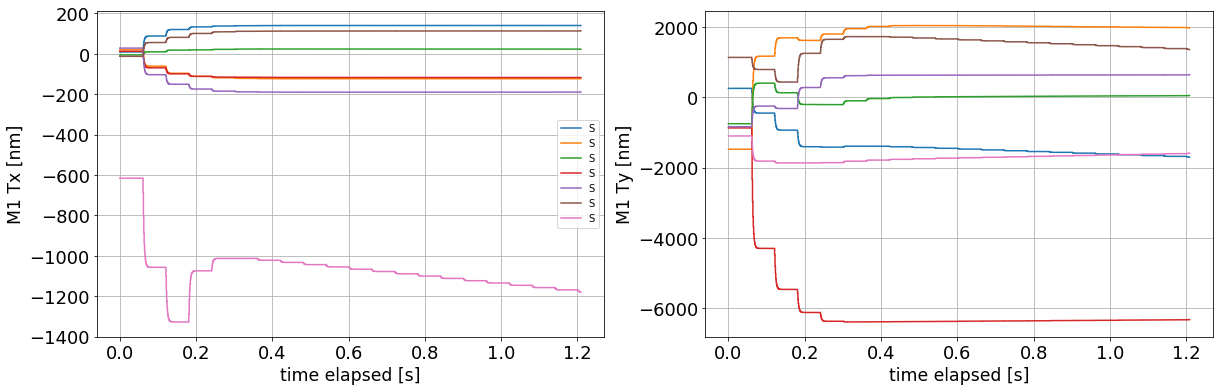

In [69]:
print('Final M1 final piston (Tx, Ty) values [nm]:')
print(np.array_str(gmt.M1.motion_CS.origin[:,0]*1e9, precision=3, suppress_small=True))
print(np.array_str(gmt.M1.motion_CS.origin[:,1]*1e9, precision=3, suppress_small=True))
print('-----')
print('Final M2 final piston (Tx, Ty) values [nm]:')
print(np.array_str(gmt.M2.motion_CS.origin[:,0]*1e9, precision=3, suppress_small=True))
print(np.array_str(gmt.M2.motion_CS.origin[:,1]*1e9, precision=3, suppress_small=True))


if VISU == True and simul_ActO_control==True:
    #f1, ((ax1,ax2),(ax3,ax4)) = plt.subplots(ncols=2, nrows=2)
    #f1.set_size_inches(20,10)
    f1, ((ax1,ax2)) = plt.subplots(ncols=2, nrows=1)
    f1.set_size_inches(20,6)

    ax1.plot(timeVec, M1TrVecIter_gCr[:,0,:].T*1e9, label='S', drawstyle='steps-post')
    ax1.grid()
    ax1.set_xlabel('time elapsed [s]', size='xx-large')
    ax1.set_ylabel('M1 Tx [nm]', size='xx-large')
    ax1.tick_params(labelsize=18)
    ax1.legend()  

    ax2.plot(timeVec, M1TrVecIter[:,1,:].T*1e9, label='S', drawstyle='steps-post')
    ax2.grid()
    ax2.set_xlabel('time elapsed [s]', size='xx-large')
    ax2.set_ylabel('M1 Ty [nm]', size='xx-large')
    ax2.tick_params(labelsize=18)

    """ax3.plot(timeCorVec, M2TrVecIter[:,0,:].T*1e9, label='S', drawstyle='steps-post')
    ax3.grid()
    ax3.set_xlabel('time elapsed [s]', size='xx-large')
    ax3.set_ylabel('M2 Tx [nm]', size='xx-large')
    ax3.tick_params(labelsize=18)
    #ax3.legend()  

    ax4.plot(timeCorVec, M2TrVecIter[:,1,:].T*1e9, label='S', drawstyle='steps-post')
    ax4.grid()
    ax4.set_xlabel('time elapsed [s]', size='xx-large')
    ax4.set_ylabel('M2 Ty [nm]', size='xx-large')
    ax4.tick_params(labelsize=18)"""

### Segment Clocking (Rz) analysis

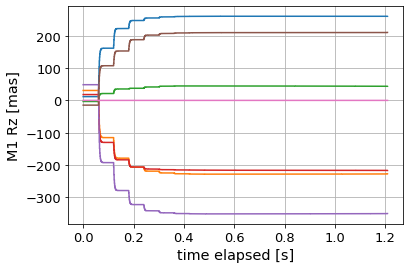

In [72]:
if VISU==True and simul_ActO_control==True:
    
    #f1, ((ax3,ax5)) = plt.subplots(ncols=2)
    f, ax3 = plt.subplots()
    ax3.axis('auto')
    #ax5.axis('auto')
    f1.set_size_inches(10,6)

    ax3.plot(timeVec, M1RotVecIter_gCr[:,2,:].T*ceo.constants.RAD2MAS, label='S', drawstyle='steps-post')
    ax3.grid()
    ax3.set_xlabel('time elapsed [s]', size='x-large')
    ax3.set_ylabel('M1 Rz [mas]', size='x-large')
    ax3.tick_params(labelsize=13)
    #ax3.legend() 

    """ax5.plot(timeCorVec, M2RotVecIter[:,2,:].T*ceo.constants.RAD2MAS, label='S', drawstyle='steps-post')
    ax5.grid()
    ax5.set_xlabel('time elapsed [s]', size='xx-large')
    ax5.set_ylabel('M2 Rz [mas]', size='xx-large')
    ax5.tick_params(labelsize=18)
    #ax5.legend() """


## Residual M1 segment bending modes

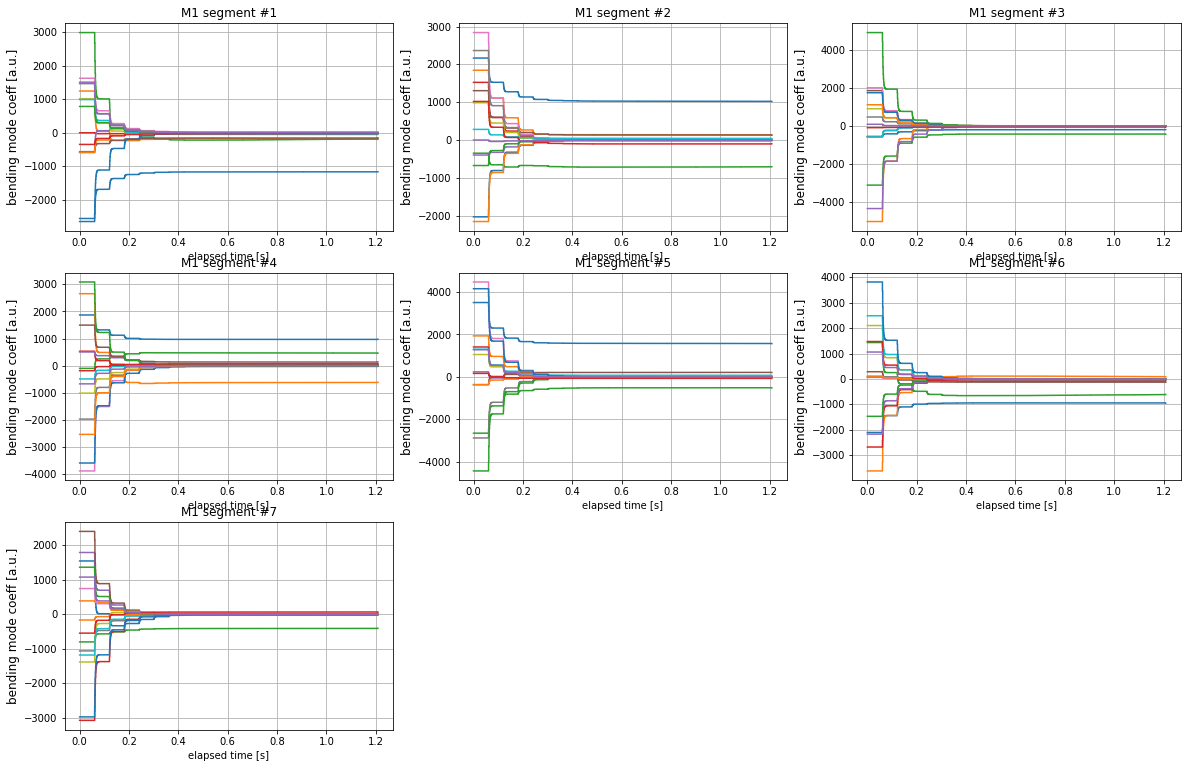

In [73]:
if simul_ActO_control==True and VISU==True:
    f1, ax = plt.subplots(ncols=3, nrows=3)
    f1.set_size_inches(20,13)
    for jj in range(7):
        thisax = (ax.ravel())[jj]
        thisax.plot(timeVec, a_M1_iter[jj,:,:].T*1e9, drawstyle='steps-post')
        thisax.grid()
        thisax.set_title('M1 segment #%d'%(jj+1), size='large')
        thisax.set_xlabel('elapsed time [s]')
        thisax.set_ylabel('bending mode coeff [a.u.]', size='large')
        #thisax.set_ylim([-10e3,10e3])
    for k in range(7,9):
        (ax.ravel())[k].axis('off')

## AGWS sensors data analysis

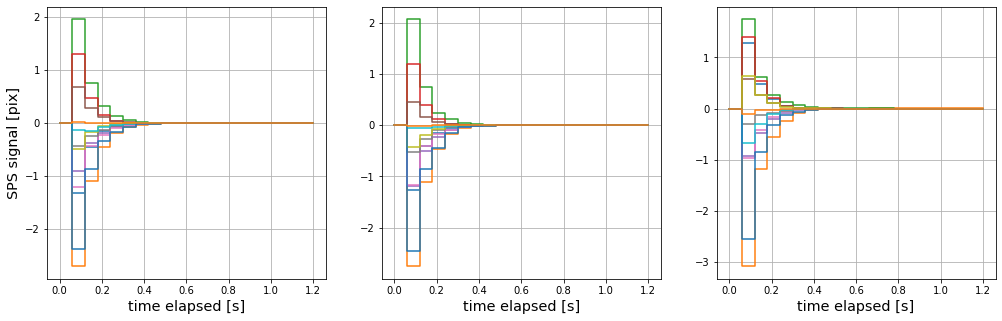

In [74]:
if simul_ActO_control==True and VISU==True:
    f1, ax = plt.subplots(ncols=gsps.N_SRC)
    f1.set_size_inches(17,5)
    pp=0
    for thisax in ax:
        thisax.plot(timeCorVec, SPSmeas_iter[pp*12:(pp+1)*12,:].T, drawstyle='steps-post')
        thisax.grid()
        thisax.set_xlabel('time elapsed [s]', size='x-large')
        if pp==0: thisax.set_ylabel('SPS signal [pix]', size='x-large')
        thisax.tick_params(labelsize=10)
        pp+=1
        #ax1.set_ylim([-0.3,0.3])

seg piston [nm WF RMS] on PS GSs: 83.8, 83.4, 85.8


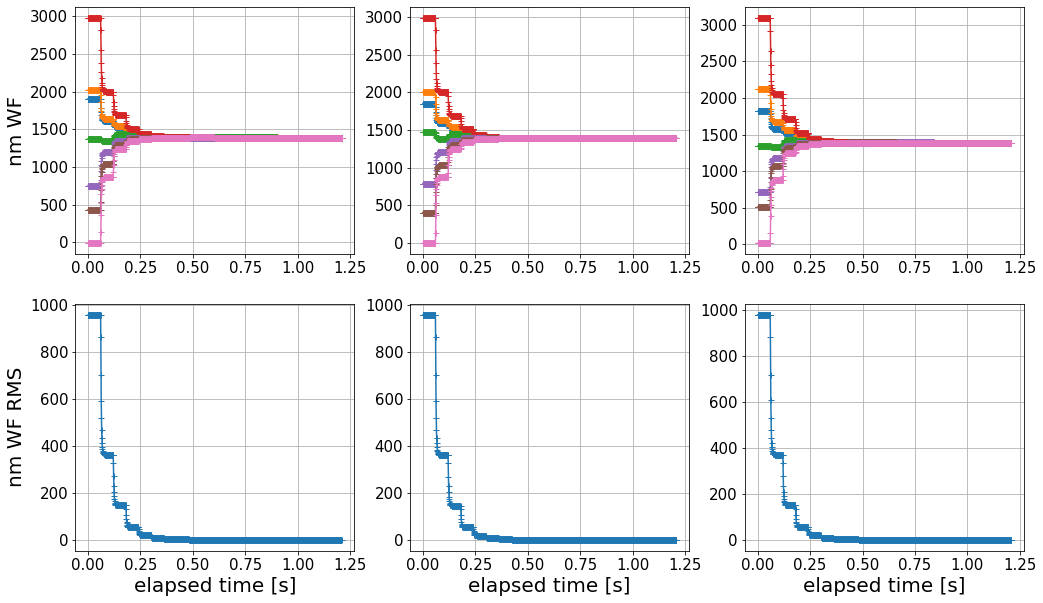

In [75]:
if eval_perf_sps==True and VISU==True:

    seg_pist_rms_sps_iter = np.std(seg_pist_sps_iter, axis=1)

    #### off-axis segment piston (at the three SPS directions) vs. iteration number 
    fig, ax = plt.subplots(ncols=gsps.N_SRC, nrows=2)
    fig.set_size_inches(17,10)

    for kk in range(N_GS_PS):
        (ax.ravel())[kk].plot(timeVec, seg_pist_sps_iter[kk,:,:].T, '-+')
        (ax.ravel())[kk].grid()
        #(ax.ravel())[kk].set_xlabel('elapsed time [min]', fontsize=20)
        if kk==0: (ax.ravel())[kk].set_ylabel('nm WF', fontsize=20)
        (ax.ravel())[kk].tick_params(labelsize=15)
        #(ax.ravel())[kk].set_ylim([-2e3,2e3])

    for kk in range(N_GS_PS):
        (ax.ravel())[kk+N_GS_PS].plot(timeVec, seg_pist_rms_sps_iter[kk,:], '-+')
        (ax.ravel())[kk+N_GS_PS].grid()
        (ax.ravel())[kk+N_GS_PS].set_xlabel('elapsed time [s]', fontsize=20)
        if kk==0: (ax.ravel())[kk+N_GS_PS].set_ylabel('nm WF RMS', fontsize=20)
        (ax.ravel())[kk+N_GS_PS].tick_params(labelsize=15)
        #(ax.ravel())[kk+N_GS_PS].set_ylim([-2e3,2e3])
        
    print("seg piston [nm WF RMS] on PS GSs: %0.1f, %0.1f, %0.1f"%((np.std(seg_pist_sps_iter[0,:,75:]),
                                                                   np.std(seg_pist_sps_iter[1,:,75:]),
                                                                   np.std(seg_pist_sps_iter[2,:,75:]))))

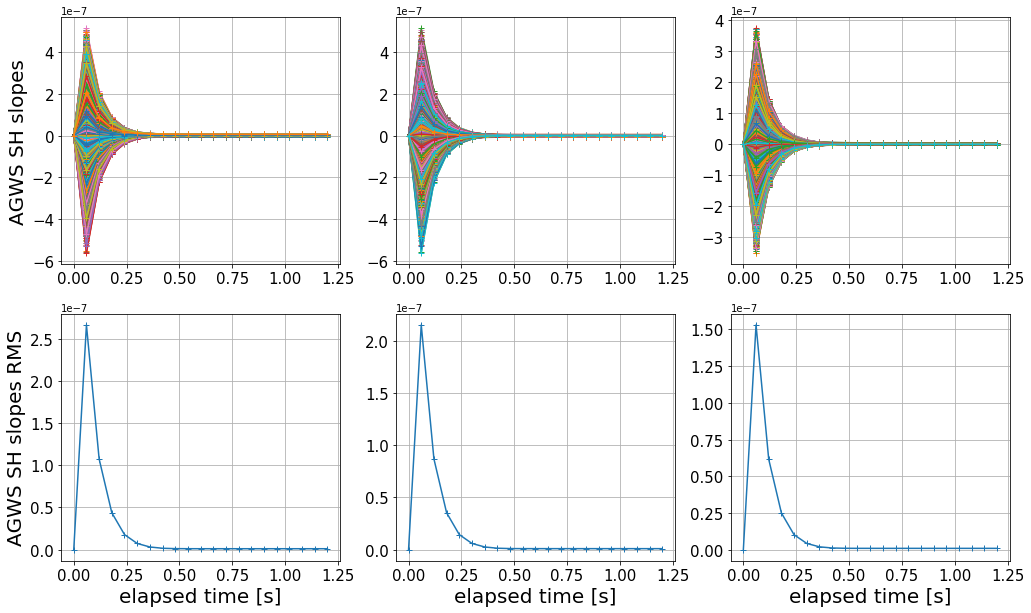

In [76]:
if simul_ActO_control==True and VISU==True:
    
    scount = np.cumsum(np.append([0],n_subaps_all))
    agws_slopes_rms_iter = np.std(agws_slopes_iter, axis=0)

    #### off-axis segment piston (at the three SPS directions) vs. iteration number 
    fig, ax = plt.subplots(ncols=agws_gs.N_SRC, nrows=2)
    fig.set_size_inches(17,10)

    for kk in range(N_GS_PS):
        (ax.ravel())[kk].plot(timeCorVec, agws_slopes_iter[scount[kk]*2:scount[kk+1]*2,:].T, '-+')
        (ax.ravel())[kk].grid()
        #(ax.ravel())[kk].set_xlabel('elapsed time [min]', fontsize=20)
        if kk==0: (ax.ravel())[kk].set_ylabel('AGWS SH slopes', fontsize=20)
        (ax.ravel())[kk].tick_params(labelsize=15)

    for kk in range(N_GS_PS):
        agws_slopes_rms_iter = np.std(agws_slopes_iter[scount[kk]*2:scount[kk+1]*2,:], axis=0)
        (ax.ravel())[kk+N_GS_PS].plot(timeCorVec, agws_slopes_rms_iter, '-+')
        (ax.ravel())[kk+N_GS_PS].grid()
        (ax.ravel())[kk+N_GS_PS].set_xlabel('elapsed time [s]', fontsize=20)
        if kk==0: (ax.ravel())[kk+N_GS_PS].set_ylabel('AGWS SH slopes RMS', fontsize=20)
        (ax.ravel())[kk+N_GS_PS].tick_params(labelsize=15)

## Do some computations...

In [77]:
print('Final M1 rotations (Rx, Ry) values [mas]:')
print(np.array_str(gmt.M1.motion_CS.euler_angles[:,0]*ceo.constants.RAD2MAS, precision=3, suppress_small=True))
print(np.array_str(gmt.M1.motion_CS.euler_angles[:,1]*ceo.constants.RAD2MAS, precision=3, suppress_small=True))
print('-----')
print('Final M2 rotations (Rx, Ry) values [mas]:')
print(np.array_str(gmt.M2.motion_CS.euler_angles[:,0]*ceo.constants.RAD2MAS, precision=3, suppress_small=True))
print(np.array_str(gmt.M2.motion_CS.euler_angles[:,1]*ceo.constants.RAD2MAS, precision=3, suppress_small=True))
print('-----')

aBr =1.11e-2  # arcmin^-1
Dseg = 8.4 #meter
Tx_Br = gmt.M1.motion_CS.euler_angles[:,0]*Dseg/4.  #in m RMS SURF
Ty_Br = gmt.M1.motion_CS.euler_angles[:,1]*Dseg/4.  #in m RMS SURF
theta_off = 45.0 # in arcsec
FDSPx_Br = Tx_Br*2*1e9 * (aBr*np.abs(theta_off)/60) * 2   #in nm RMS WF
FDSPy_Br = Ty_Br*2*1e9 * (aBr*np.abs(theta_off)/60) * 2   #in nm RMS WF

print("Estimated FDSP at %3.1f arcsec:"%theta_off)
print(np.array_str(FDSPx_Br, precision=3, suppress_small=True))
print(np.array_str(FDSPy_Br, precision=3, suppress_small=True))

Final M1 rotations (Rx, Ry) values [mas]:
[ -9.798   9.528  -0.603 -34.072   2.485   6.274  -9.062]
[  4.393   6.73  -13.362   5.307   0.678 -10.577   6.722]
-----
Final M2 rotations (Rx, Ry) values [mas]:
[0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0.]
-----
Estimated FDSP at 45.0 arcsec:
[ -3.322   3.23   -0.204 -11.552   0.843   2.127  -3.072]
[ 1.489  2.282 -4.53   1.799  0.23  -3.586  2.279]
